<a href="https://colab.research.google.com/github/JonMcEntee/ieee-cis-fraud-detection/blob/main/IEEE_CIS_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import csv

import warnings
warnings.filterwarnings('ignore')

from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, auc, get_scorer
from sklearn.model_selection import cross_validate
from sklearn.impute import SimpleImputer, MissingIndicator, IterativeImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import average_precision_score, roc_auc_score

from xgboost import XGBClassifier

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from scipy.stats import pearsonr, spearmanr, kendalltau, ttest_ind, chisquare

from statistics import mean

from plotnine import ggplot, aes, geom_histogram, \
                     theme_tufte, labs, element_text, \
                     theme, element_line, scale_y_continuous, \
                     facet_wrap, after_stat, labeller

from collections import Counter

from ast import literal_eval

from itertools import product

from tqdm.notebook import tqdm

random_state = 102

In [ ]:
# Mount into drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
train_identity = pd.read_csv("./drive/My Drive/ieee-fraud-detection/train_identity.csv")
train_transaction = pd.read_csv("./drive/My Drive/ieee-fraud-detection/train_transaction.csv")
# test_identity = pd.read_csv("./drive/My Drive/ieee-fraud-detection/test_identity.csv")
# test_transaction = pd.read_csv("./drive/My Drive/ieee-fraud-detection/test_transaction.csv")

# Exploratory Data Analysis

This section explores the data prior to training our models

## Data Description

Data description from [this post](https://www.kaggle.com/competitions/ieee-fraud-detection/discussion/101203) on Kaggle.

from `train_transaction.csv`:

*   `TransactionDT`: timedelta from a given reference datetime (not an actual timestamp)
*   `TransactionAMT`: transaction payment amount in USD
*   `ProductCD`: product code, the product for each transaction
*   `card1` - `card6`: payment card information, such as card type, card category, issue bank, country, etc.
*   `addr`: address
*   `dist`: distance
*   `P_` and (`R_`) `emaildomain`: purchaser and recipient email domain
*   `C1` - `C14`: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
*   `D1` - `D15`: timedelta, such as days between previous transaction, etc.
*   `M1` - `M9`: match, such as names on card and address, etc.
*   `Vxxx`: Vesta engineered rich features, including ranking, counting and other entity relations.

from `train_identity.csv`:

*   `id01` - `id11`: are numerical features for identity, which are collected by Vesta and security partners such as device rating, ip_domain rating, proxy rating, etc. Also it recorded behavioral fingerprint like account login times/failed to login times, how long an account stayed on the page, etc. All of these are not able to elaborate due to security partner T&C.
*   `id_30`: the operating system of the device
*   `id_31`: the web browser the device is using
*   `id_33`: the resolution of the device's screen output
*   `DeviceType`: can be `mobile` or `desktop`
*   `DeviceInfo`: combined information about the device and perhaps its operating system.

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.

They're collected by Vesta’s fraud protection system and digital security partners.

(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)


## Feature Importances

Since we cannot analyze all 400+ features in this dataset, I ran a random forest with the following parameters (`n_estimators=1000, max_depth=10, class_weight={0: 5, 1: 95}, min_samples_split=32, min_samples_leaf=32`) and chose the top 6 features with the highest importance to the model. Those features are, in order of importance: `C14`, `C13`, `V264`, `V317`, `V258`, `V294`, `V257`, and `C4`.

In [ ]:
 pd.read_csv("./drive/My Drive/ieee-fraud-detection/output/feature_importances.csv", index_col = 0)[:20]

,Importance
Feature,
C14,0.014253
C13,0.012990
V264,0.011999
V317,0.011758
V258,0.011646
V294,0.011530
C8,0.011135
V318,0.011028
V257,0.010560



## Unsupervised Feature Analysis

In [ ]:
def unsupervised_hist(feature, bins=30):
  return ggplot(train_transaction, aes(x=feature)) + geom_histogram(bins = bins) + \
    labs(title=f"Distribution of Feature {feature}",  x=f"Value of {feature}", y="Frequency") + \
    theme_tufte() + \
    theme(panel_grid_major_y = element_line(color=".9"),
          panel_grid_minor_y = element_line(color=".9")) + \
    scale_y_continuous(trans='log10')

### C14

`C14` is essentially bimodal. There is a massive peak at the value of `1.0`. The frequency of then declines rapidly until an upswing to a second, far smaller peak at the value of `110`. Looking at the histogram it appears that there may be other local modes in the data but these two appear to be the most significant.

In [ ]:
train_transaction.C14.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

,C14
0.1,1.0
0.2,1.0
0.3,1.0
0.4,1.0
0.5,1.0
0.6,1.0
0.7,2.0
0.8,3.0
0.9,5.0
1.0,1429.0


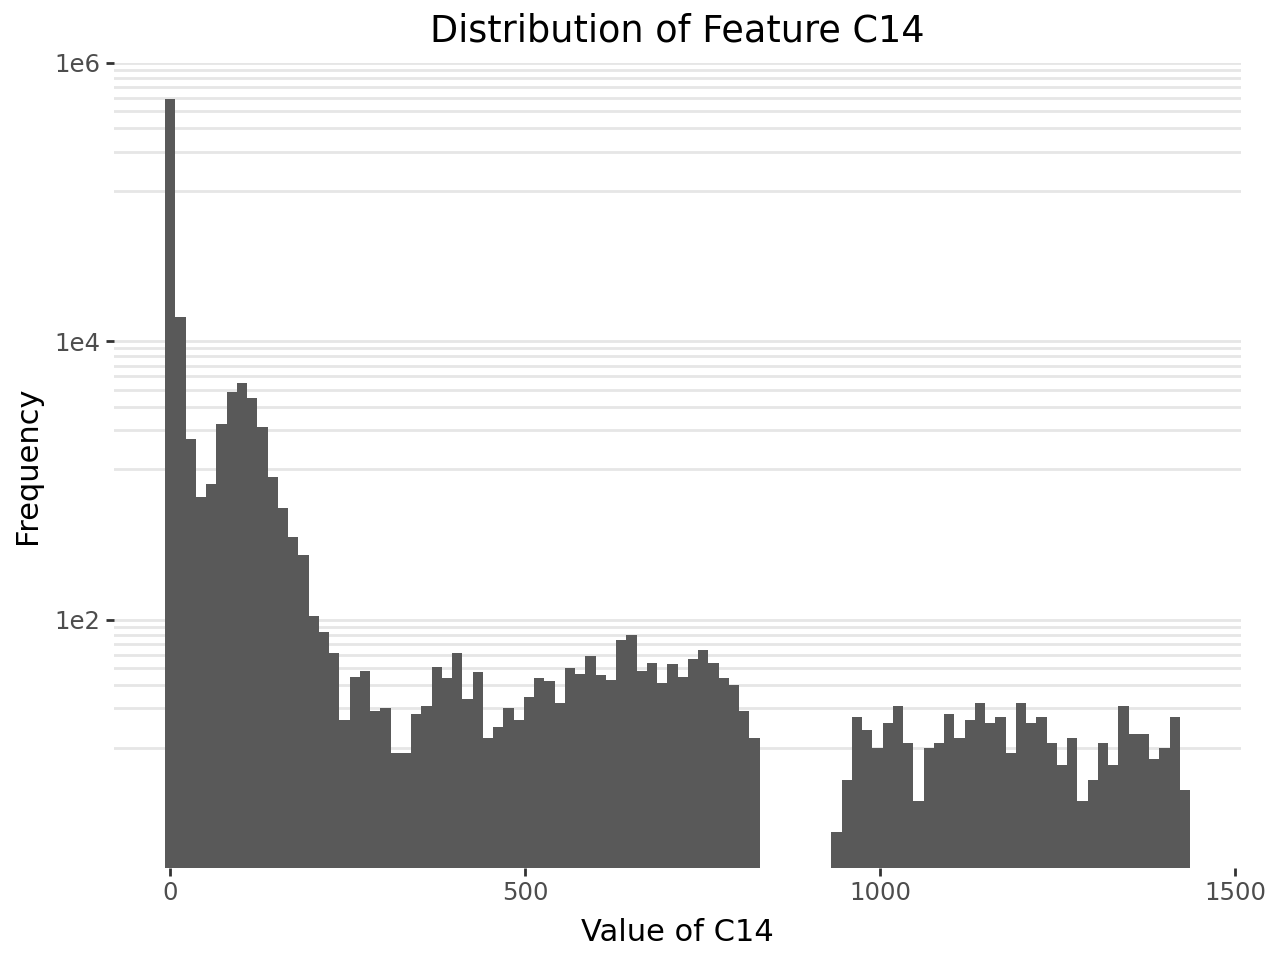

In [ ]:
unsupervised_hist('C14', bins=100)

### C13

`C13` is unimodal. Its value peaks at `1.0` and declines thereafter.

In [ ]:
train_transaction.C14.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

,C14
0.1,1.0
0.2,1.0
0.3,1.0
0.4,1.0
0.5,1.0
0.6,1.0
0.7,2.0
0.8,3.0
0.9,5.0
1.0,1429.0


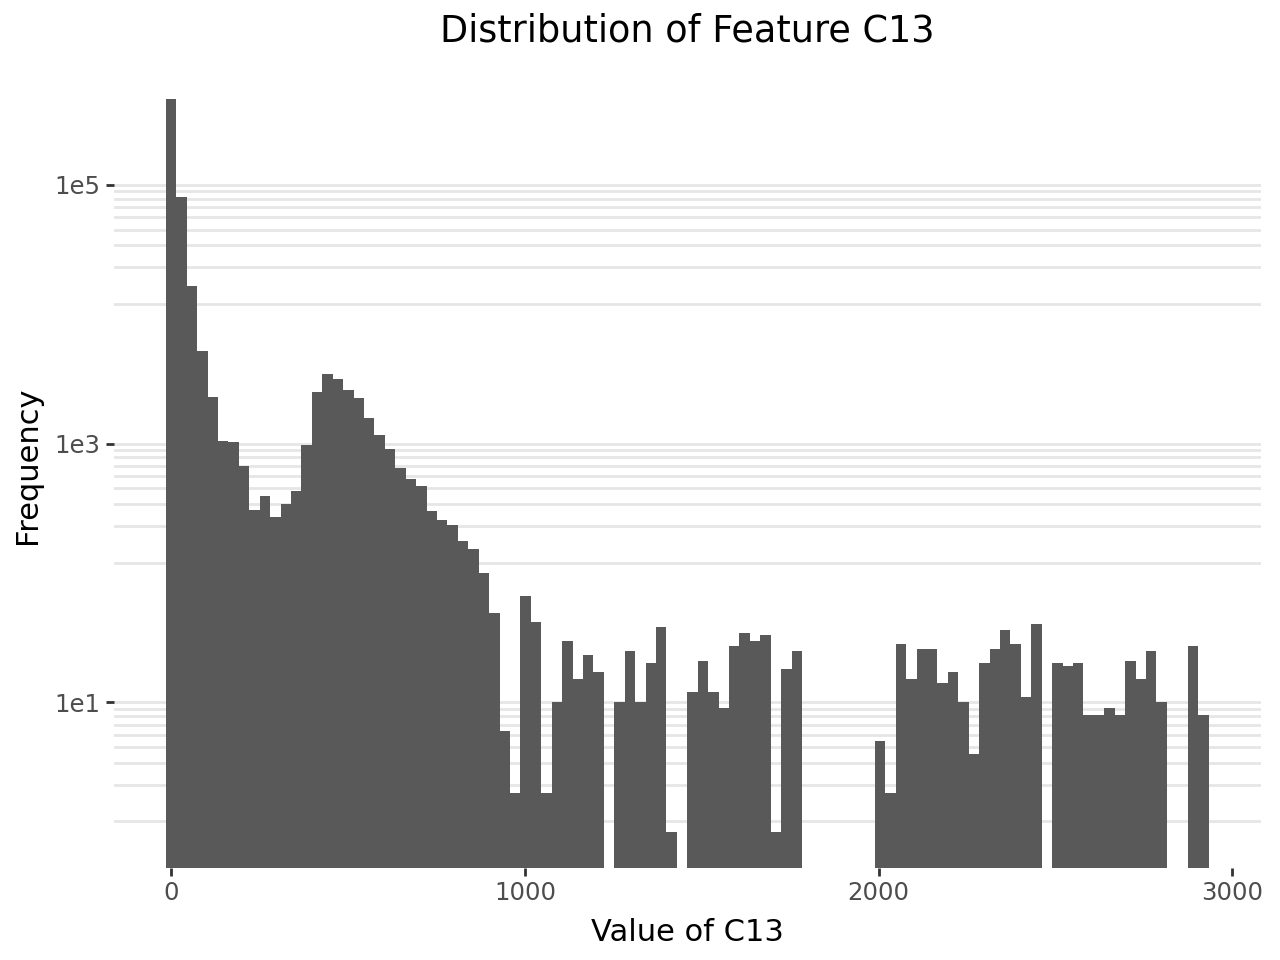

In [ ]:
unsupervised_hist('C13', bins=100)

### V264

`V264` has a multimodal distribution. The largest mode is at `0.0`, but there are many other local modes that pop up at seemingly regular intervals. For example 50, 100, 150, 200, and so on.

In [ ]:
train_transaction.V264.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

,V264
0.1,0.0000
0.2,0.0000
0.3,0.0000
0.4,0.0000
0.5,0.0000
0.6,0.0000
0.7,8.9422
0.8,65.0000
0.9,200.0000
1.0,153600.0000


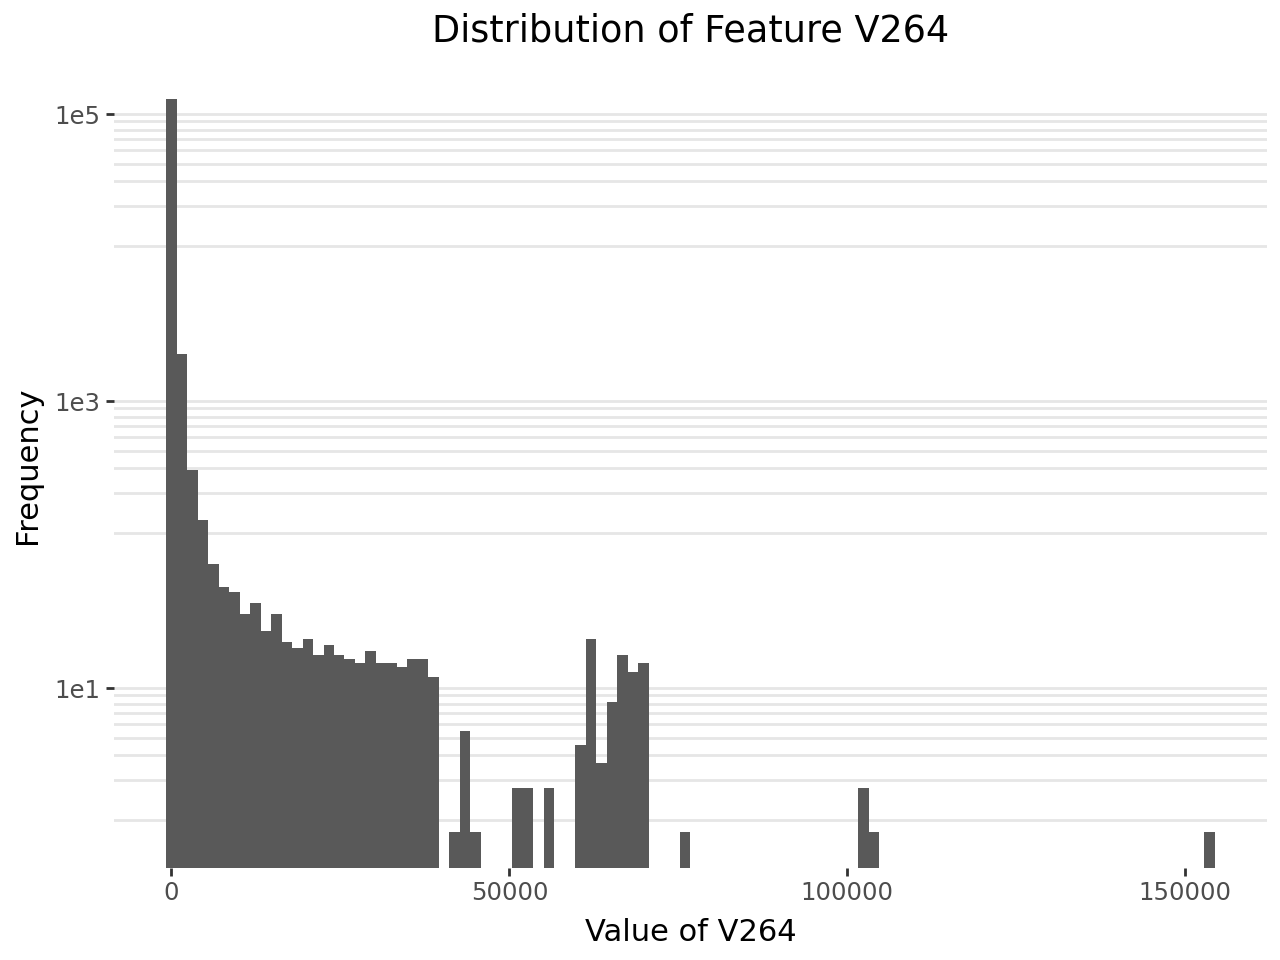

In [ ]:
unsupervised_hist('V264', bins=100)

### V317

`V317` is multimodal with the majority of data instances (greater than 80% as our quantiles below show) at `0.0`. The other modes are dispersed over a range of values as shown in the histogram.

In [ ]:
train_transaction.V317.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

,V317
0.1,0.0
0.2,0.0
0.3,0.0
0.4,0.0
0.5,0.0
0.6,0.0
0.7,0.0
0.8,0.0
0.9,58.0
1.0,134021.0


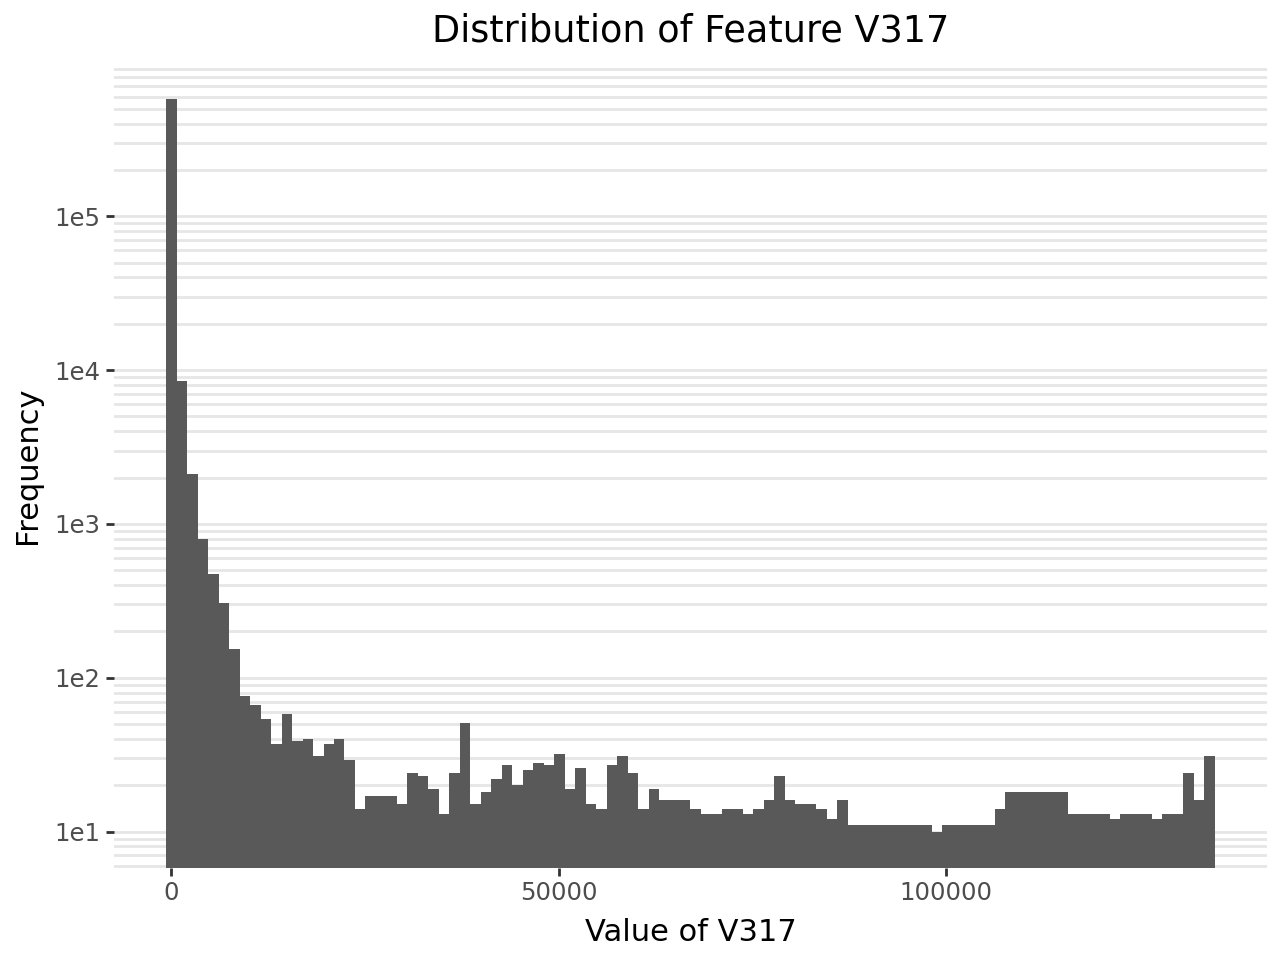

In [ ]:
unsupervised_hist('V317', bins=100)

### V258

`V258` is unimodal and right skewed. The overwhelming majority of values are set to `1.0`


In [ ]:
train_transaction.V258.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

,V258
0.1,1.0
0.2,1.0
0.3,1.0
0.4,1.0
0.5,1.0
0.6,1.0
0.7,1.0
0.8,1.0
0.9,2.0
1.0,66.0


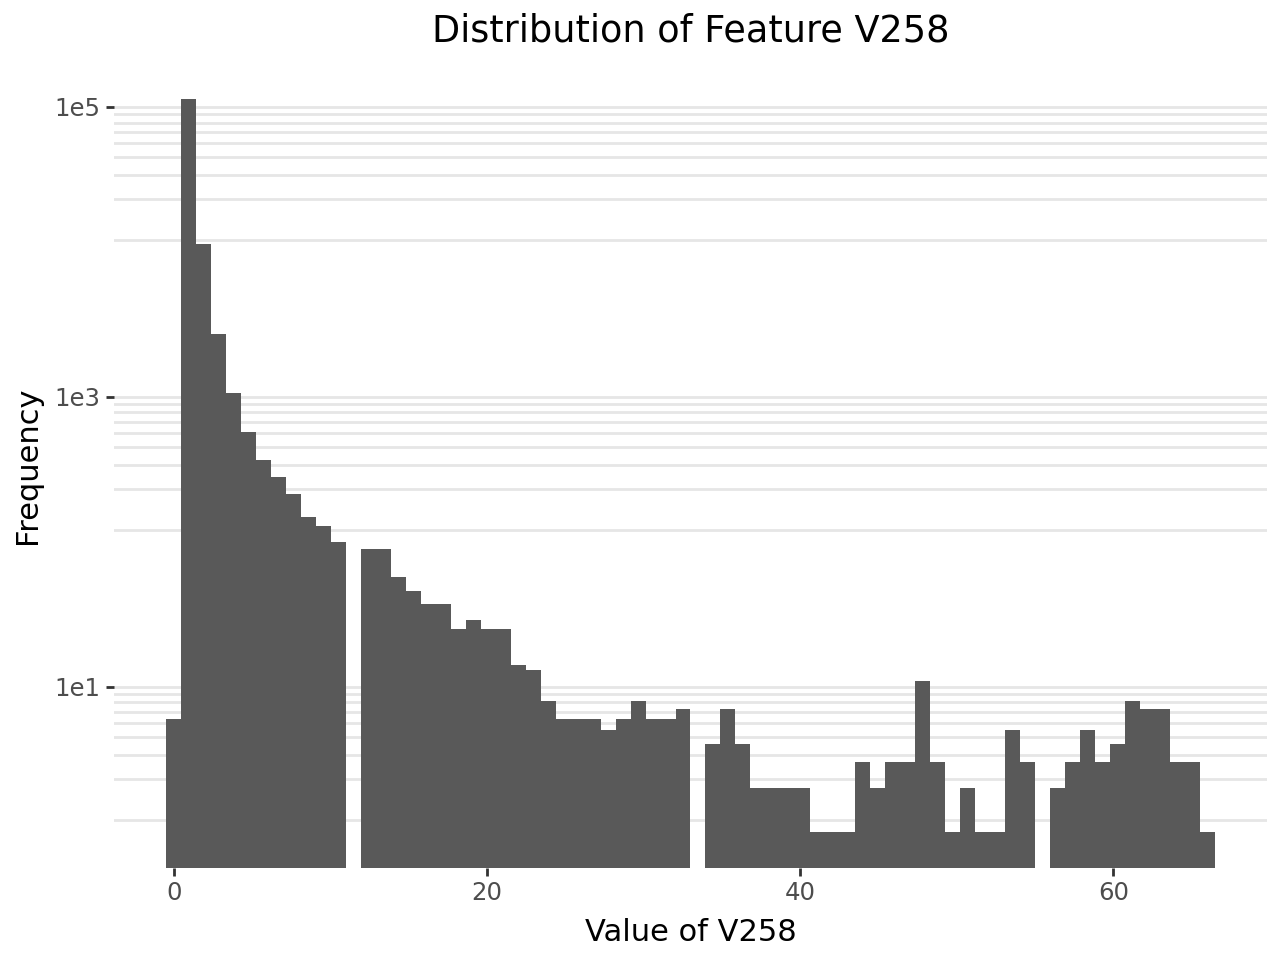

In [ ]:
unsupervised_hist('V258', bins=70)

### V294

`V294` starts with a sharp peak at `0.0` and then sharply declines. Most of distances are value `0.0`. There is however another small mode in the region of ~700-800, eyeballing the histogram

In [ ]:
train_transaction.V294.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

,V294
0.1,0.0
0.2,0.0
0.3,0.0
0.4,0.0
0.5,0.0
0.6,0.0
0.7,0.0
0.8,0.0
0.9,1.0
1.0,1286.0


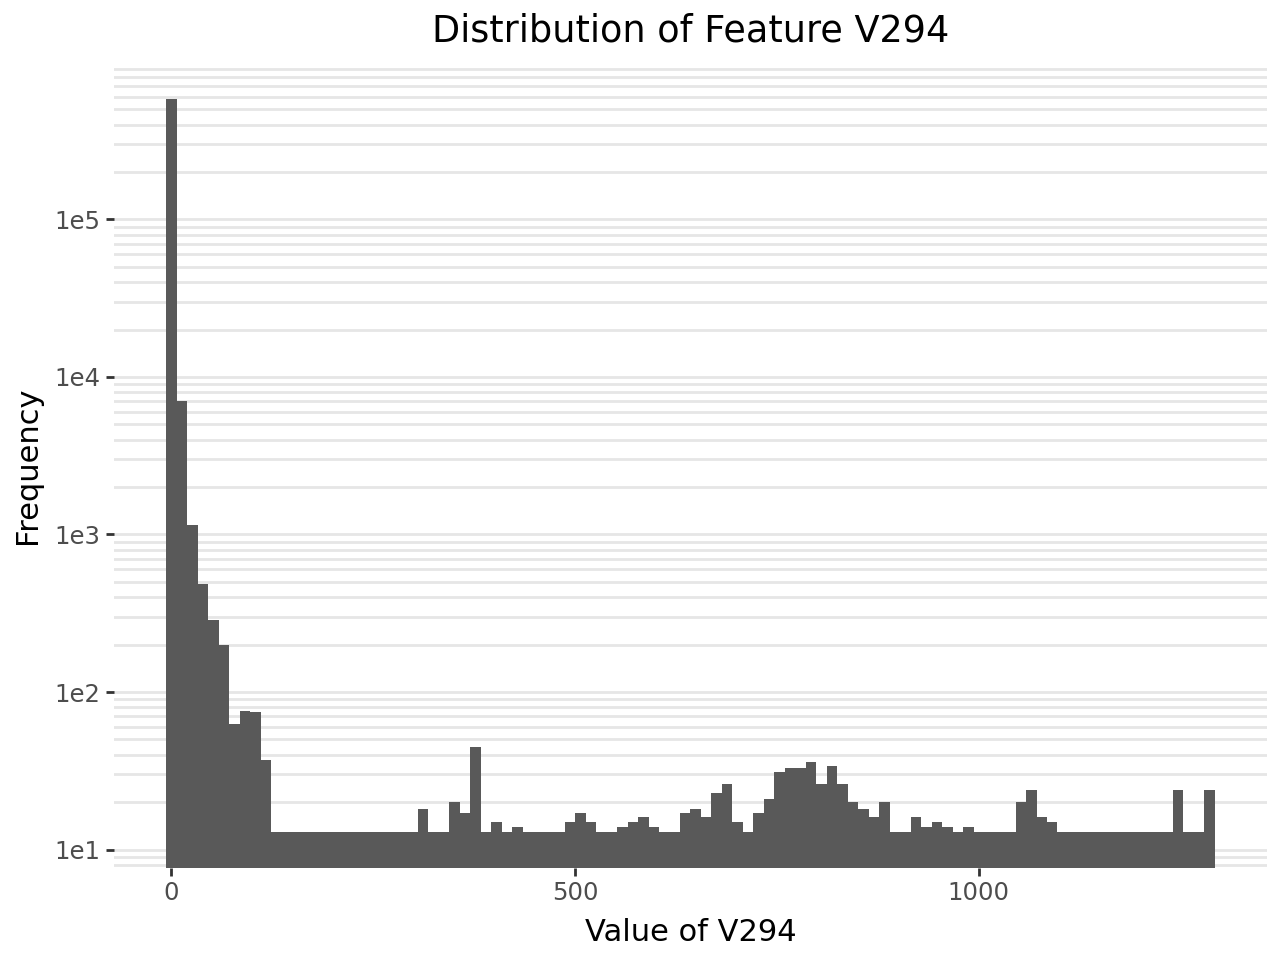

In [ ]:
unsupervised_hist('V294', bins=100)

### C8

Another feature that is heavily right skewed. As the quantiles show 90%+ of the data has a value less than or equal to `1.0`.

In [ ]:
train_transaction.C8.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

,C8
0.1,0.0
0.2,0.0
0.3,0.0
0.4,0.0
0.5,0.0
0.6,0.0
0.7,0.0
0.8,1.0
0.9,1.0
1.0,3331.0


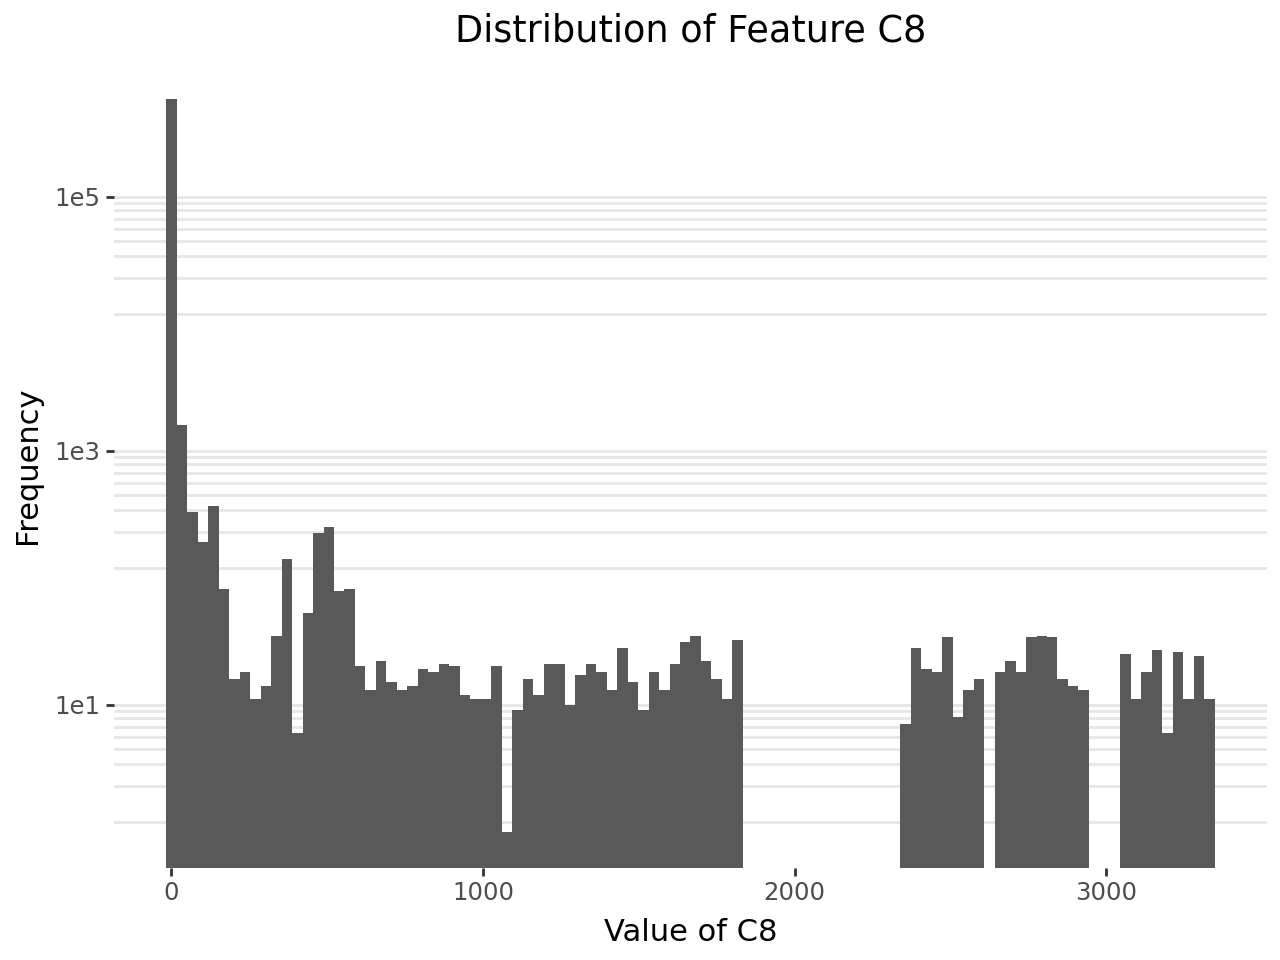

In [ ]:
unsupervised_hist('C8', bins=100)

### V318

More than 90% of data instances have a value of `0.0` but there are outliers. The distribution is unimodal with a right skew like most of our features here.

In [ ]:
train_transaction.V318.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

,V318
0.1,0.0
0.2,0.0
0.3,0.0
0.4,0.0
0.5,0.0
0.6,0.0
0.7,0.0
0.8,0.0
0.9,0.0
1.0,98476.0


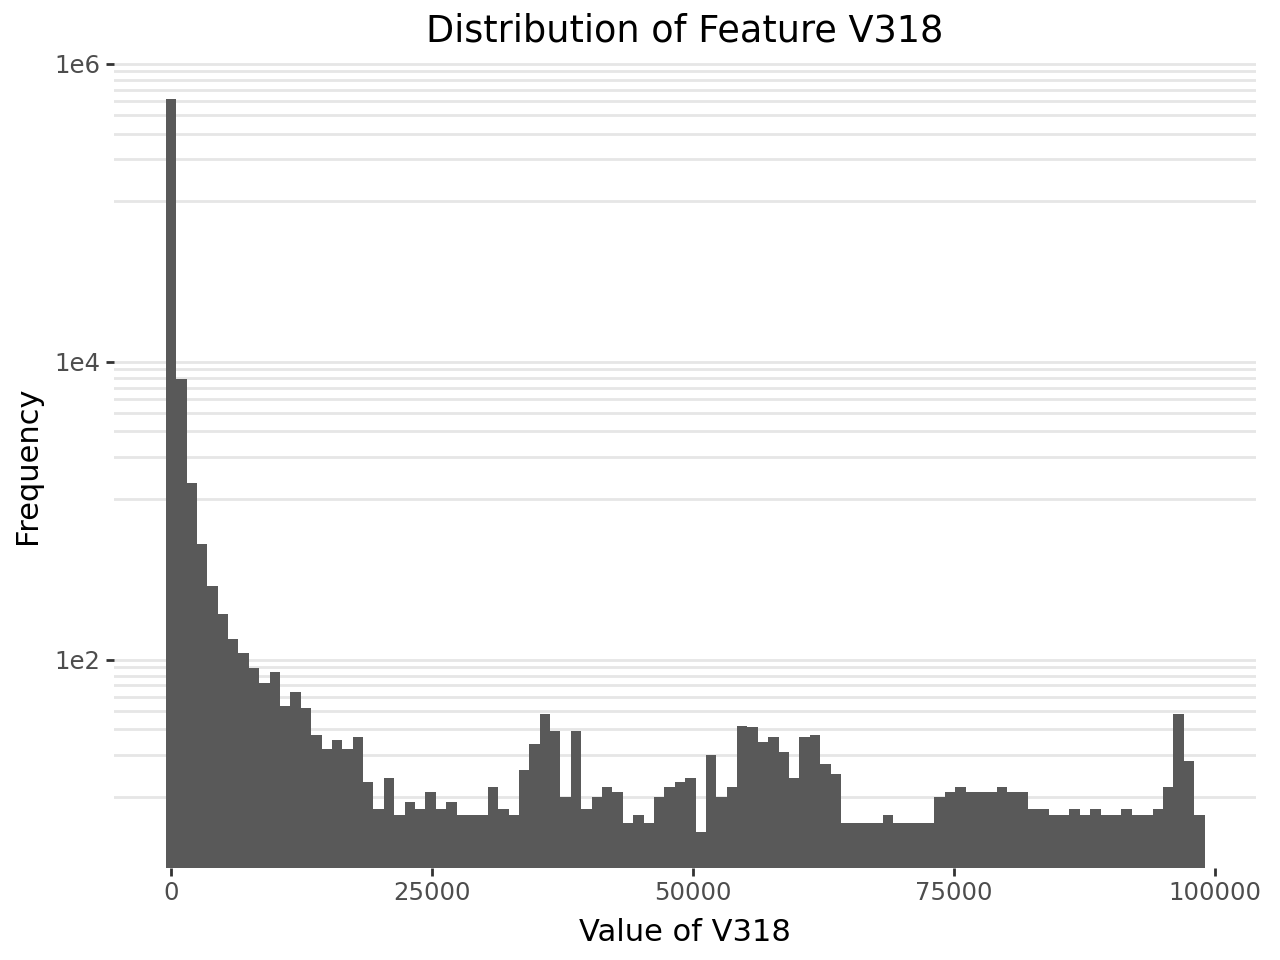

In [ ]:
unsupervised_hist('V318', bins=100)

### V257

From the quantiles we can see that more than 80% of values are less than or equal to `1.0`. This distribution is also unimodel and right skewed.

In [ ]:
train_transaction.V257.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

,V257
0.1,1.0
0.2,1.0
0.3,1.0
0.4,1.0
0.5,1.0
0.6,1.0
0.7,1.0
0.8,1.0
0.9,2.0
1.0,48.0


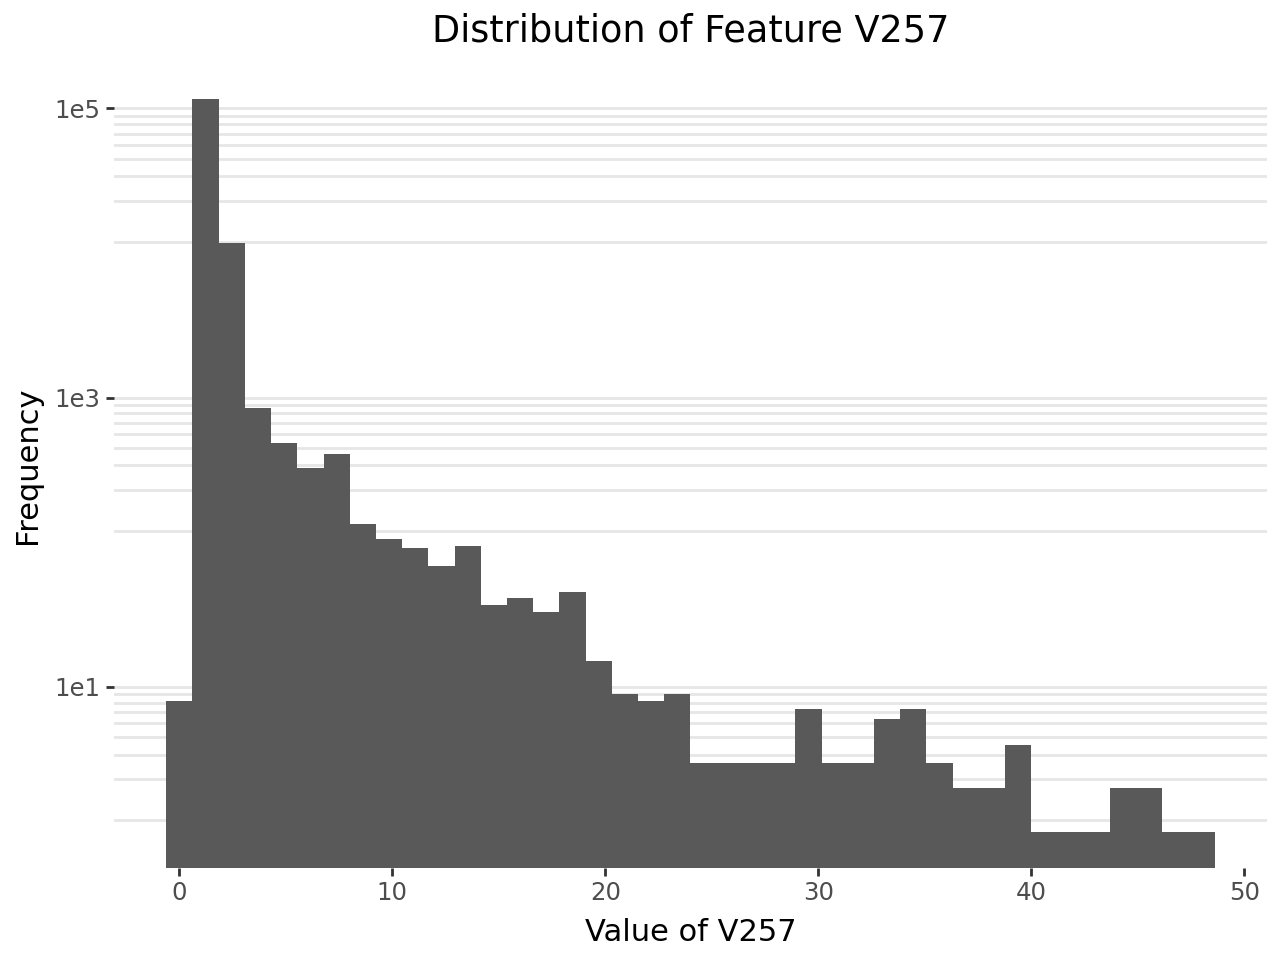

In [ ]:
unsupervised_hist('V257', bins=40)

### C4

From the quantiles we can see that more than 90% of values are less than or equal to `1.0`. It is right skewed like the others but has small local modes at larger values.

In [ ]:
train_transaction.C4.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

,C4
0.1,0.0
0.2,0.0
0.3,0.0
0.4,0.0
0.5,0.0
0.6,0.0
0.7,0.0
0.8,1.0
0.9,1.0
1.0,2253.0


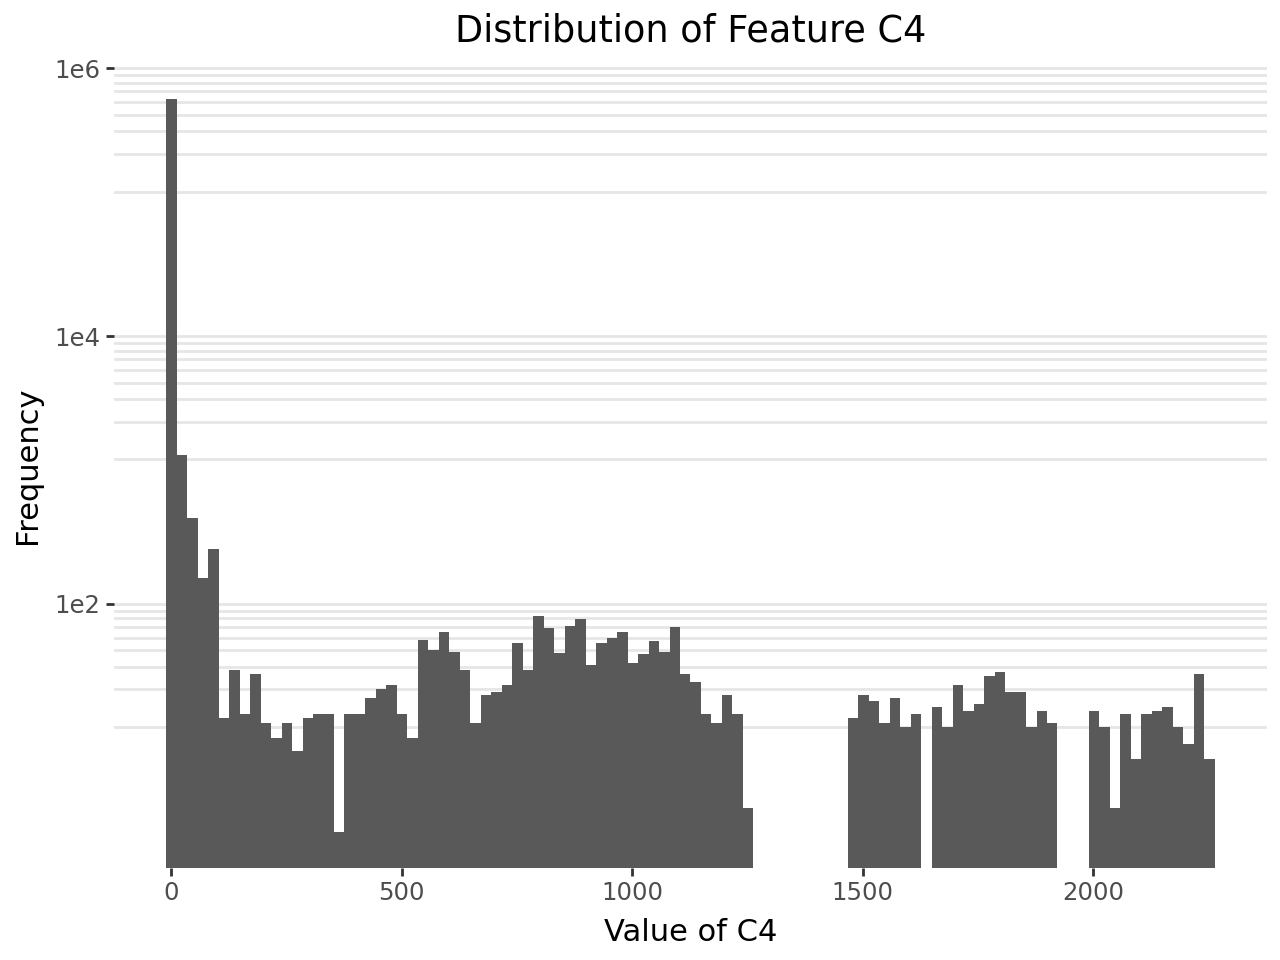

In [ ]:
unsupervised_hist('C4', bins=100)

## Supervised Feature Analysis

In [ ]:
def supervised_hist(feature, bins=30):
  return ggplot(train_transaction, aes(x=feature, y=after_stat("density"))) + geom_histogram(bins = bins) + \
    labs(title=f"Distribution of Feature {feature}",  x=f"Value of {feature}", y="Density") + \
    theme_tufte() + \
    theme(panel_grid_major_y = element_line(color=".9"),
          panel_grid_minor_y = element_line(color=".9")) + \
    scale_y_continuous(trans='log10') + \
    facet_wrap("isFraud", labeller=labeller(cols = lambda x : "Fraud" if x == '1' else "Not Fraud"))


def supervised_analysis(dataframe, features, y_column):
  pearson = []
  spearman = []
  kendall_tau = []
  test_type = []
  statistic = []
  p_value = []

  features = list(features)

  if y_column in features:
    features.remove(y_column)

  for feature in tqdm(features):

    temp_df = dataframe[["isFraud", feature]].dropna()

    numeric = False if temp_df[feature].dtype == "object" else True

    normal = temp_df[temp_df[y_column] == 0][feature]
    fraud = temp_df[temp_df[y_column] == 1][feature]

    if numeric:
      feature_as_float = temp_df[feature] = temp_df[feature].astype(float)
      # Various Correlations
      pearson.append(pearsonr(temp_df[y_column], feature_as_float)[0])
      spearman.append(spearmanr(temp_df[y_column], feature_as_float)[0])
      kendall_tau.append(kendalltau(temp_df[y_column], feature_as_float)[0])

      # Student T-Test
      t = ttest_ind(normal, fraud)
      test_type.append("Student T-Test")
      p_value.append(t.pvalue)
      statistic.append(t.statistic)
    else:
      pearson.append(np.NaN)
      spearman.append(np.NaN)
      kendall_tau.append(np.NaN)

      observed_counter = Counter(fraud)
      expected_counter = Counter(normal)

      keys = set(observed_counter.keys()).union(set(expected_counter.keys()))
      keys = list(sorted(keys))

      observed = np.array([observed_counter[key] for key in keys])
      expected = np.array([expected_counter[key] for key in keys])

      scale_factor = np.sum(expected) / np.sum(observed)
      observed_adjusted = observed * scale_factor

      expected[expected == 0] = 1e-10

      # Chi-Squared test
      cs = chisquare(f_obs=observed_adjusted, f_exp=expected)
      test_type.append("Chi-Squared")
      p_value.append(cs.pvalue)
      statistic.append(cs.statistic)

  results = {
      "Top Features" : features,
      "Pearson Correlation" : pearson,
      "Spearman Ranked" : spearman,
      "Kendall-Tau" : kendall_tau,
      "Test Type": test_type,
      "Statistic": statistic,
      "P-Value" : p_value
      }

  return pd.DataFrame(results)

if not os.path.isfile("./drive/My Drive/ieee-fraud-detection/output/supervised_feature_analysis.csv"):
  whole = train_transaction.merge(train_identity, on='TransactionID', how='left')
  analysis = supervised_analysis(whole, whole.columns, "isFraud")
  analysis.to_csv("./drive/My Drive/ieee-fraud-detection/output/supervised_feature_analysis.csv")
else:
  analysis = pd.read_csv("./drive/My Drive/ieee-fraud-detection/output/supervised_feature_analysis.csv")

analysis

,Unnamed: 0,Top Features,Pearson Correlation,Spearman Ranked,Kendall-Tau,Test Type,Statistic,P-Value
0,0,TransactionID,0.014166,0.014166,0.011566,Student T-Test,-1.088699e+01,1.337707e-27
1,1,TransactionDT,0.013103,0.014166,0.011566,Student T-Test,-1.007010e+01,7.523524e-24
2,2,TransactionAmt,0.011320,-0.001576,-0.001296,Student T-Test,-8.699444e+00,3.343462e-18
3,3,ProductCD,NaN,NaN,NaN,Chi-Squared,5.135627e+05,0.000000e+00
4,4,card1,-0.013640,-0.013431,-0.010989,Student T-Test,1.048281e+01,1.041584e-25
...,...,...,...,...,...,...,...,...
428,428,id_36,NaN,NaN,NaN,Chi-Squared,2.345356e+03,0.000000e+00
429,429,id_37,NaN,NaN,NaN,Chi-Squared,1.194548e+03,9.337071e-262
430,430,id_38,NaN,NaN,NaN,Chi-Squared,8.808697e+03,0.000000e+00
431,431,DeviceType,NaN,NaN,NaN,Chi-Squared,7.730185e+03,0.000000e+00


In [ ]:
top_features = ["C14", "C13", "V264", "V317", "V258", "V294", "C8", "V318"]

supervised_analysis(train_transaction, top_features, "isFraud")

  0%|          | 0/8 [00:00<?, ?it/s]

,Top Features,Pearson Correlation,Spearman Ranked,Kendall-Tau,Test Type,Statistic,P-Value
0,C14,0.007921,-0.062306,-0.056887,Student T-Test,-6.086861,1.152166e-09
1,C13,-0.011146,-0.075038,-0.064601,Student T-Test,8.565649,1.077204e-17
2,V264,0.009358,0.262532,0.243079,Student T-Test,-3.379674,7.259303e-04
3,V317,0.005010,0.117551,0.114048,Student T-Test,-3.849833,1.182109e-04
4,V258,0.297151,0.385553,0.378466,Student T-Test,-112.392448,0.000000e+00
5,V294,0.004241,0.117899,0.115195,Student T-Test,-3.258674,1.119405e-03
6,C8,0.032139,0.155996,0.151897,Student T-Test,-24.710232,9.726148e-135
7,V318,0.000997,0.115632,0.112943,Student T-Test,-0.766255,4.435248e-01


### C14

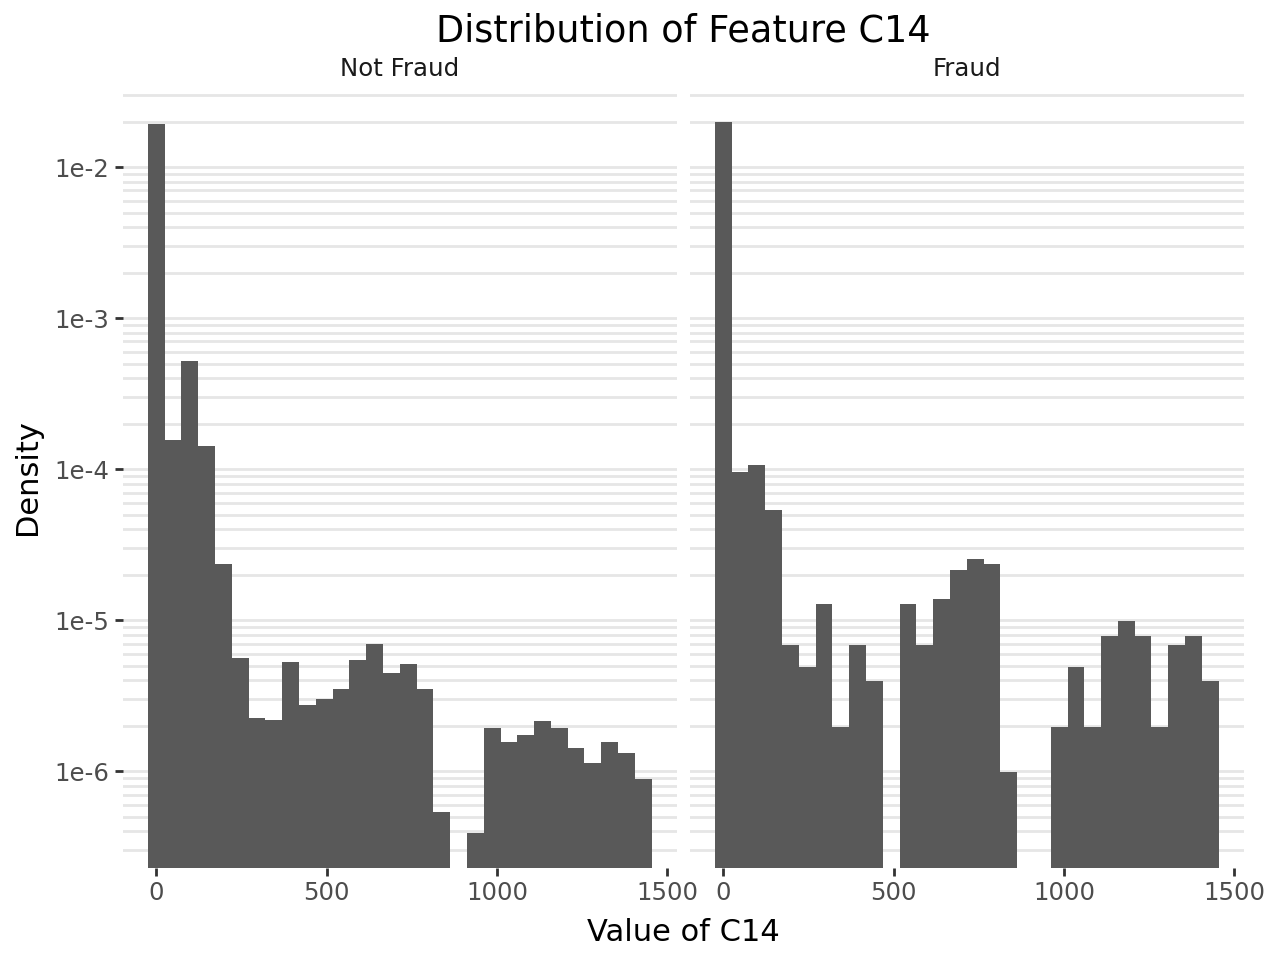

In [ ]:
supervised_hist("C14", bins=30)

### C13

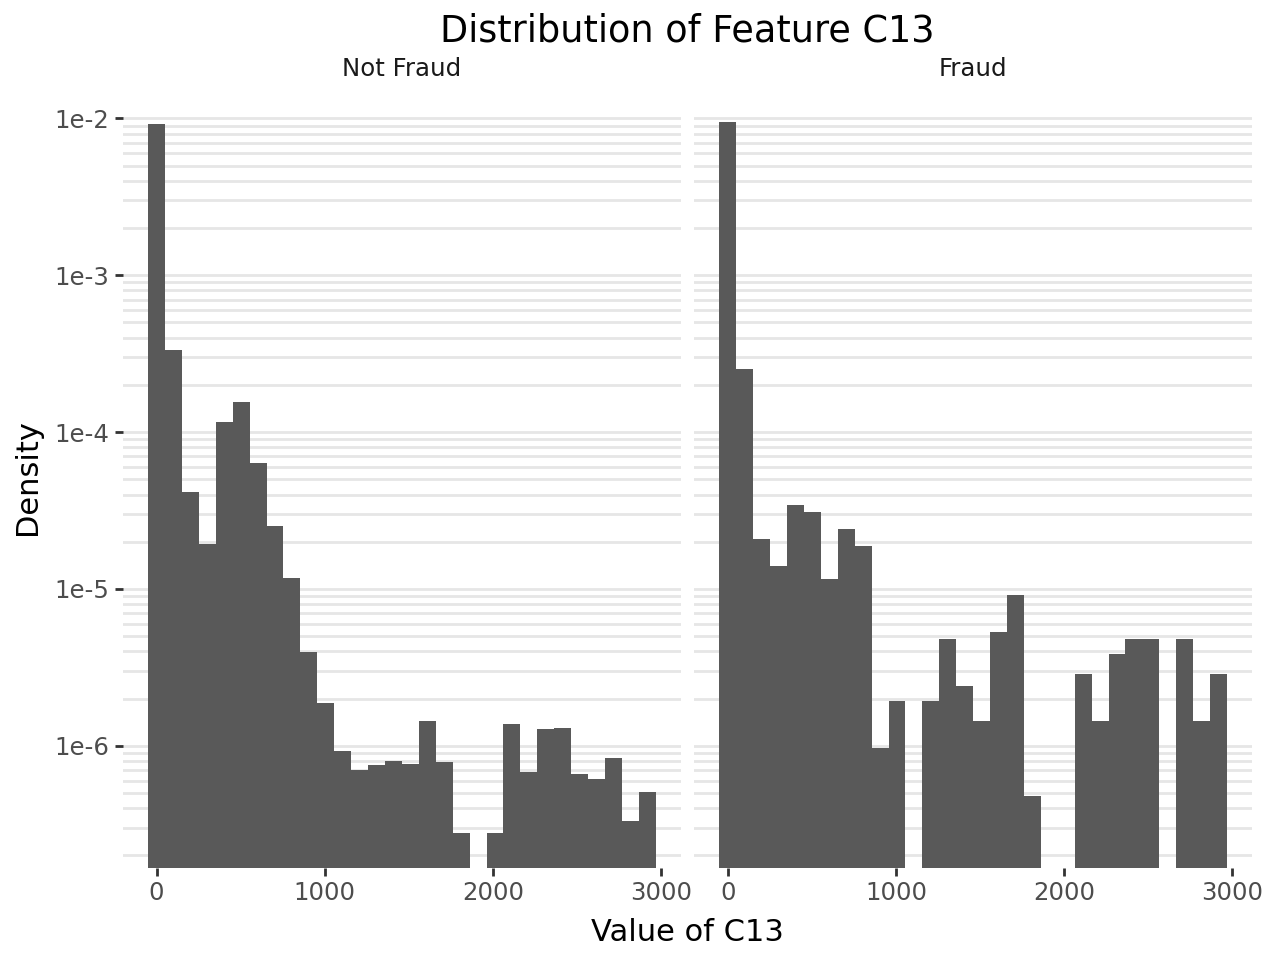

In [ ]:
supervised_hist("C13", bins=30)

### V264

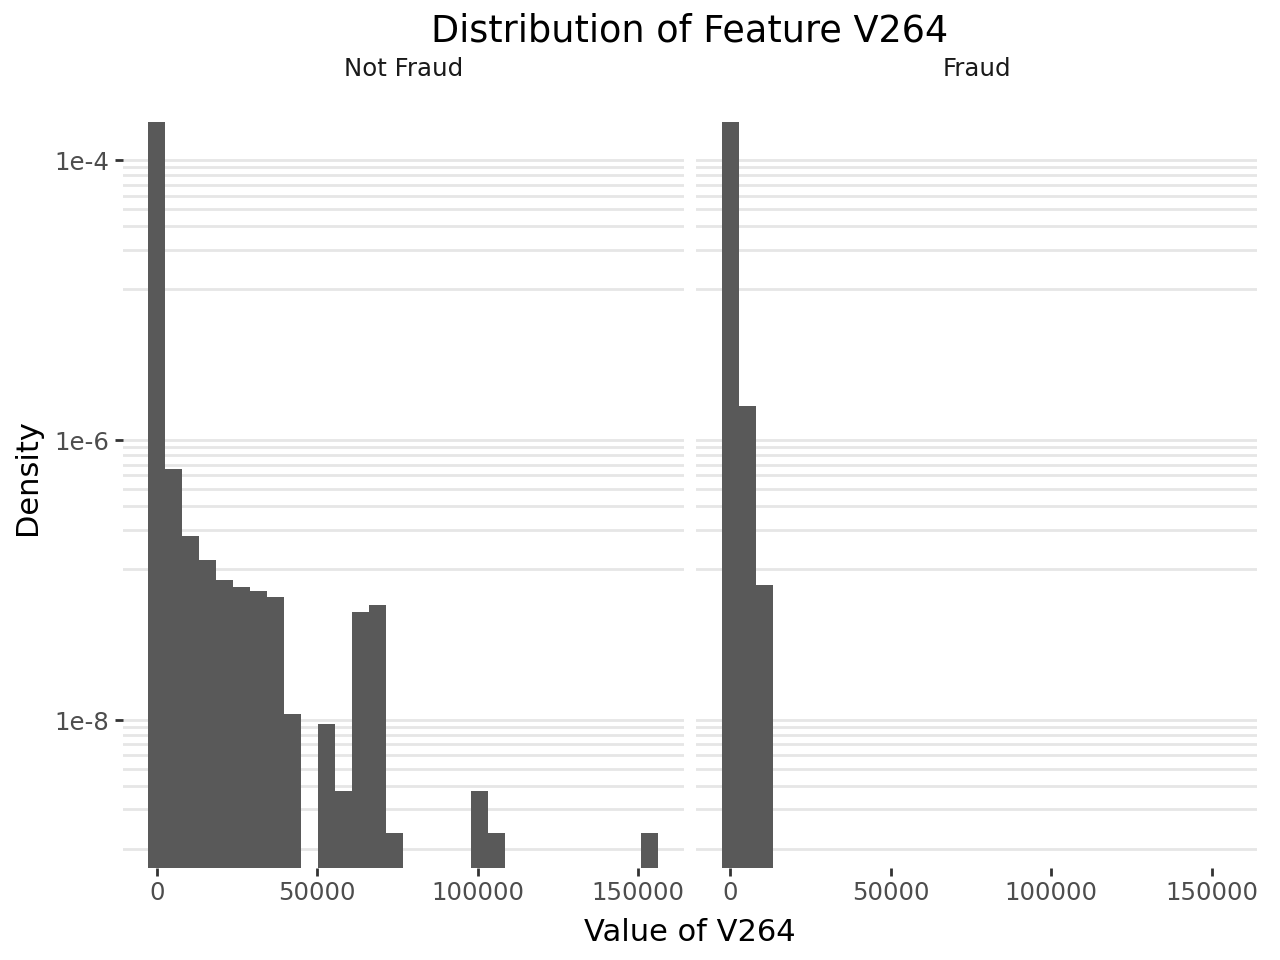

In [ ]:
supervised_hist("V264", bins=30)

### V317

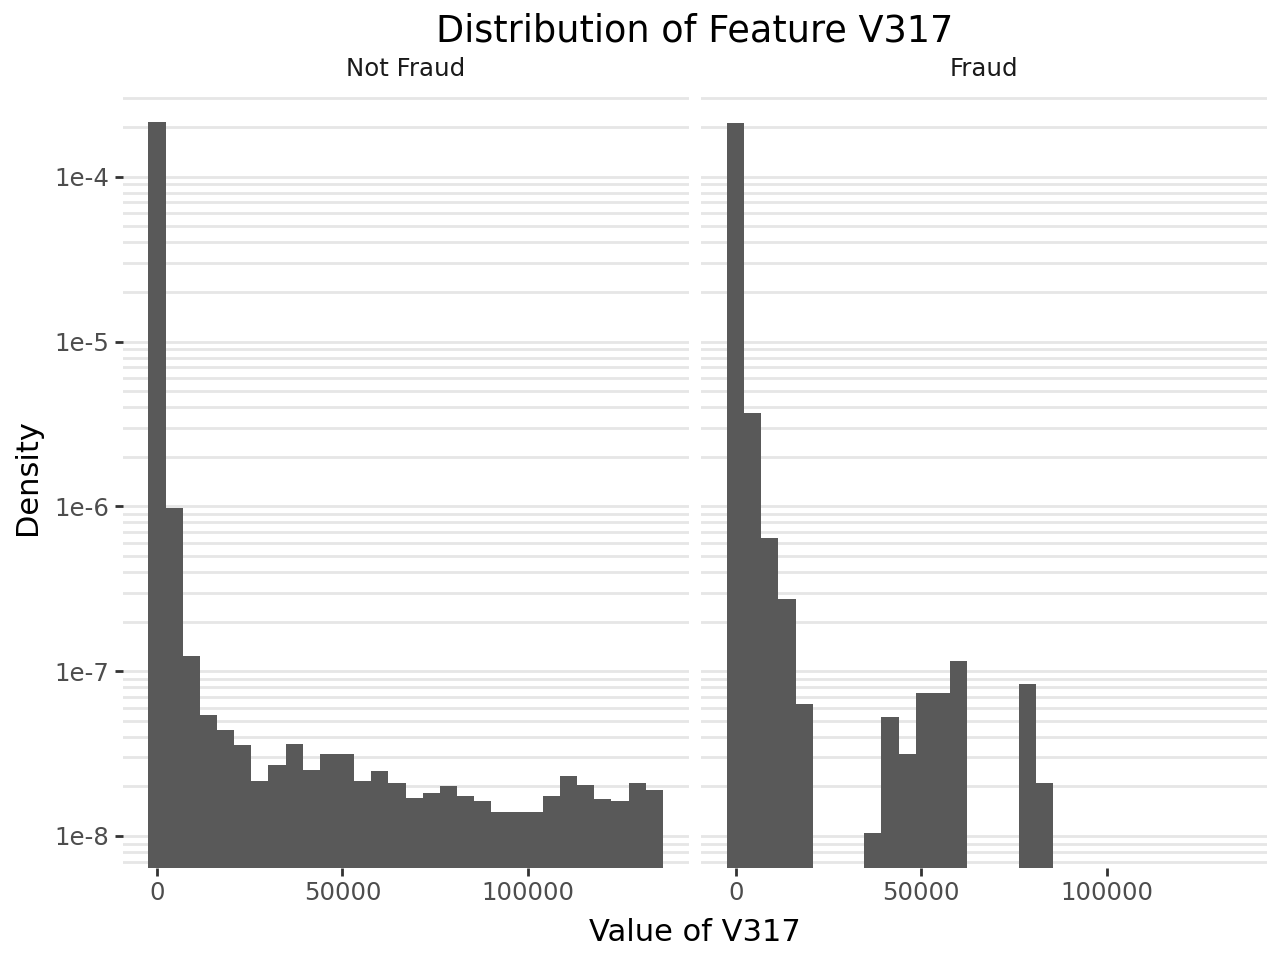

In [ ]:
supervised_hist("V317", bins=30)

### V258

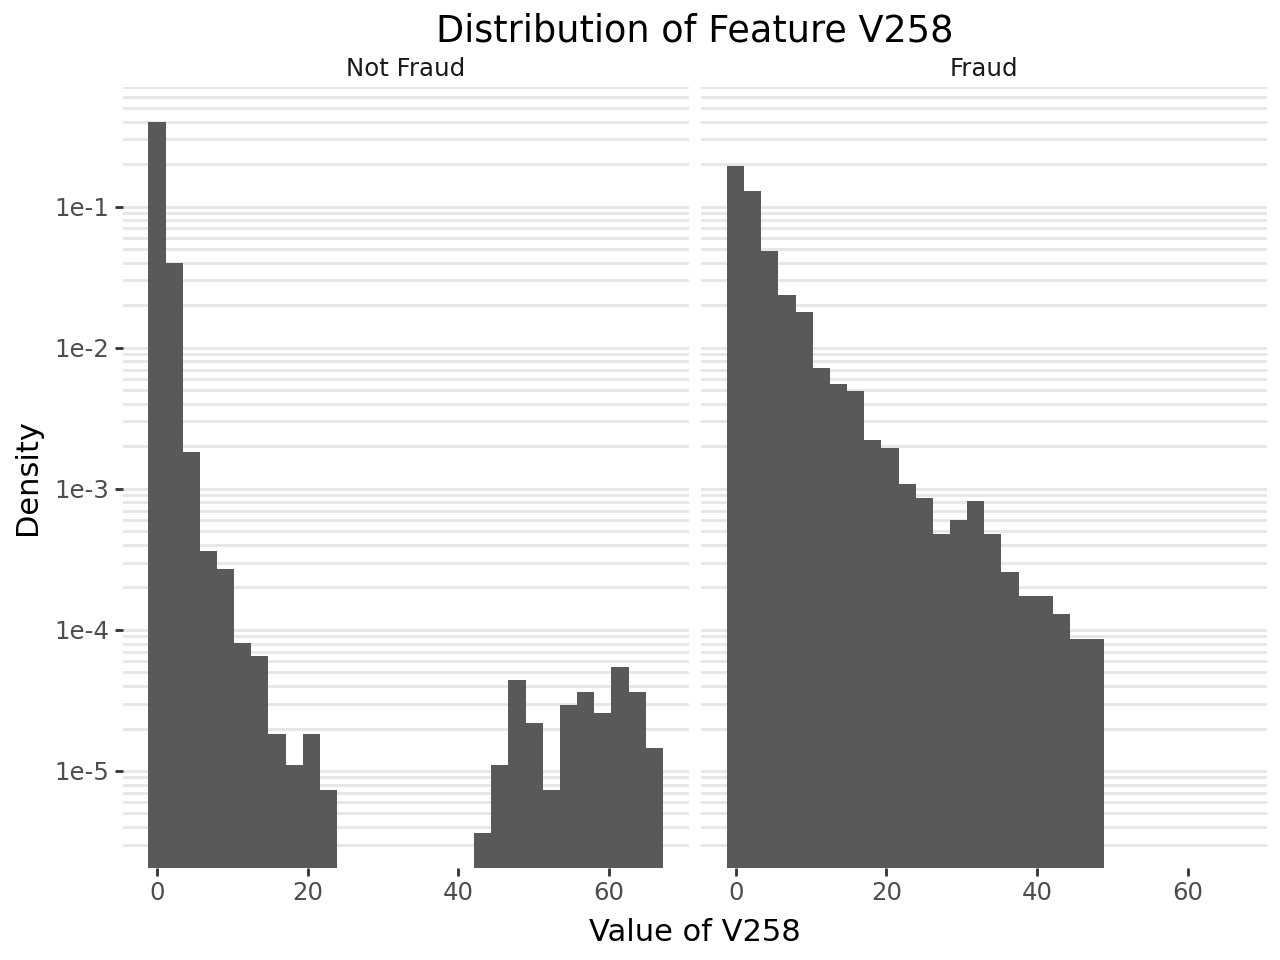

In [ ]:
supervised_hist("V258", bins=30)

### V294

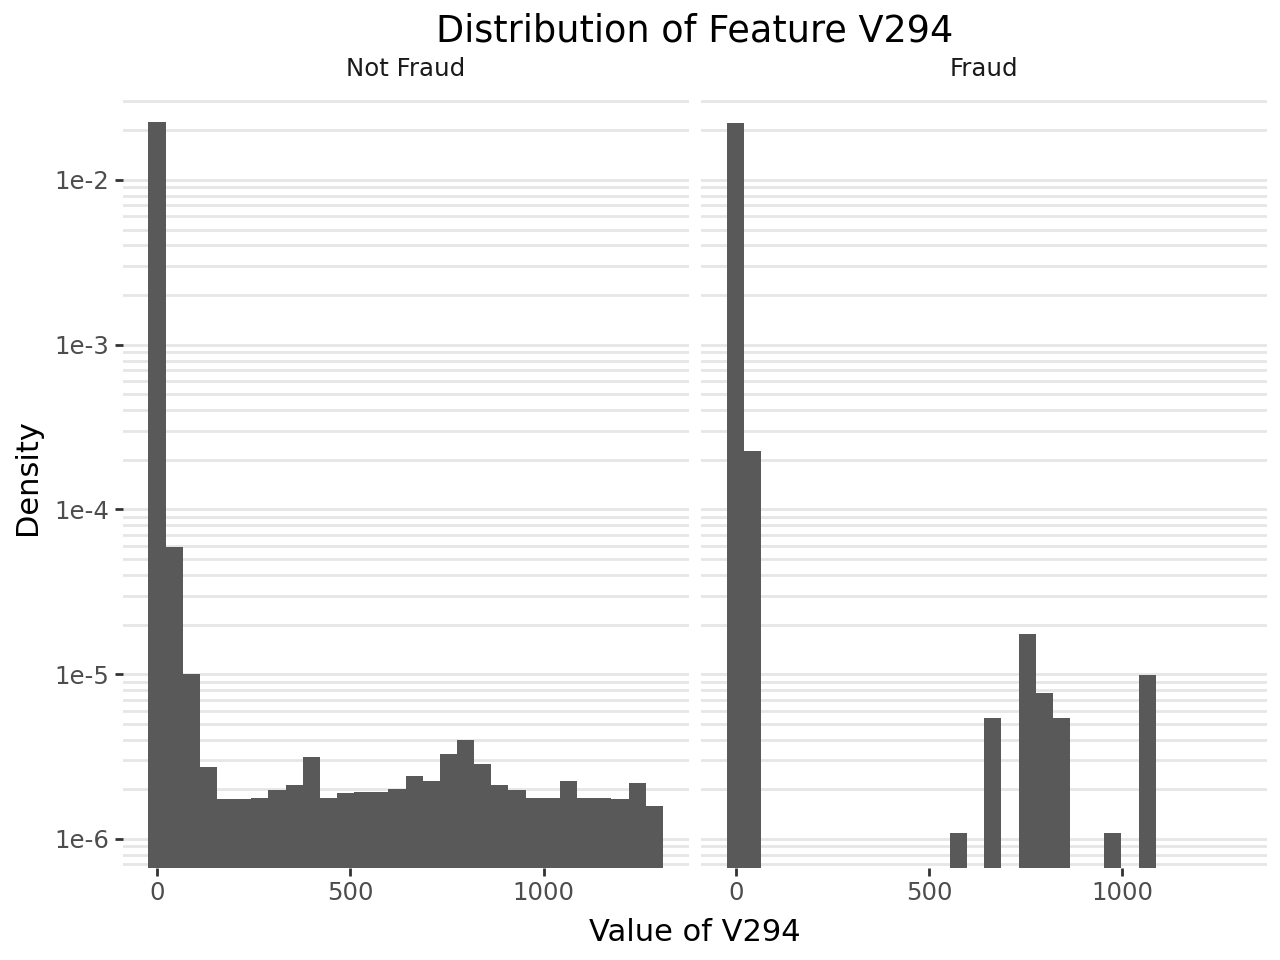

In [ ]:
supervised_hist("V294", bins=30)

### C8

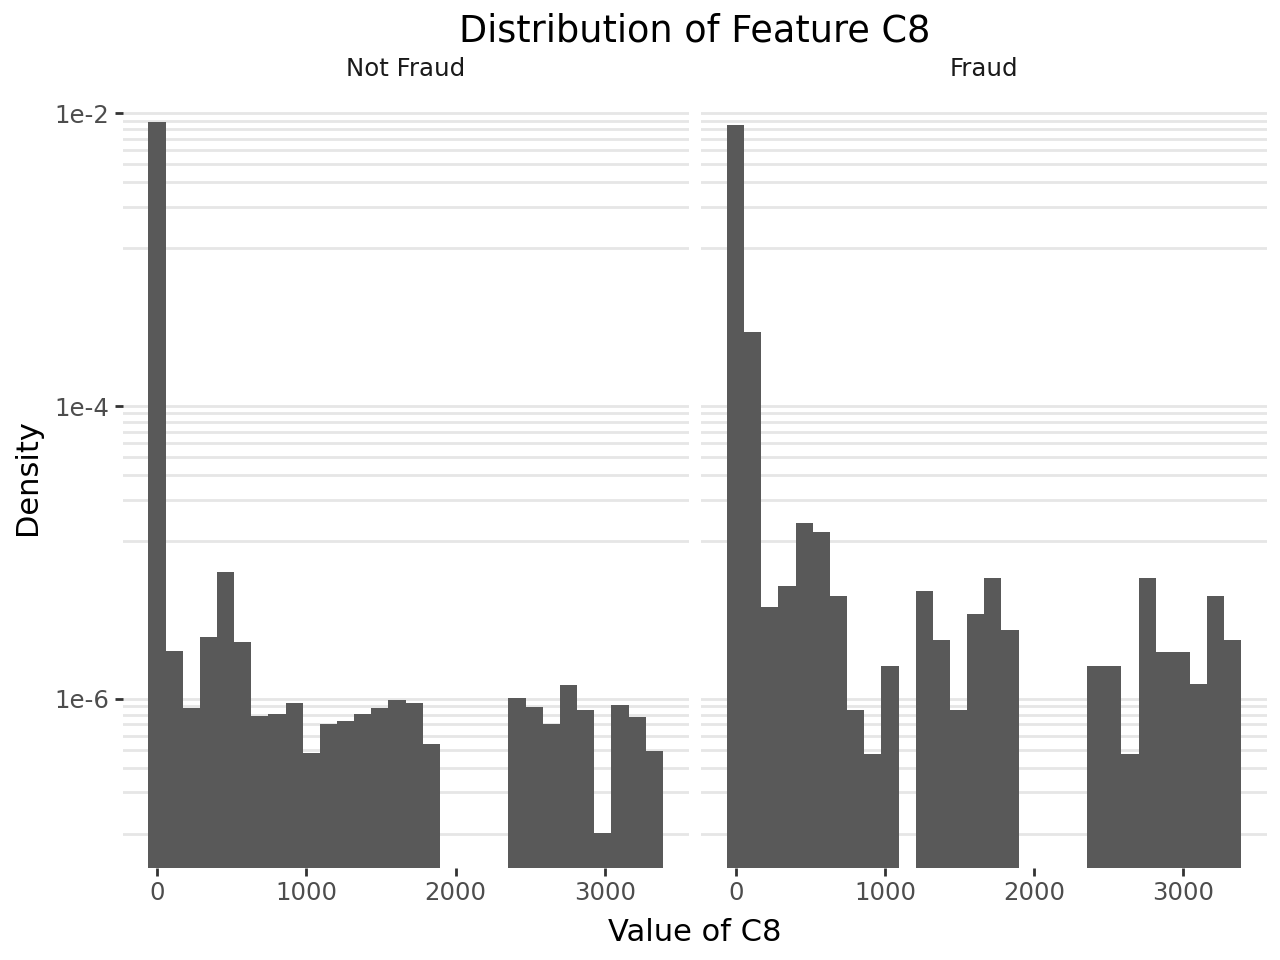

In [ ]:
supervised_hist("C8", bins=30)

### V318

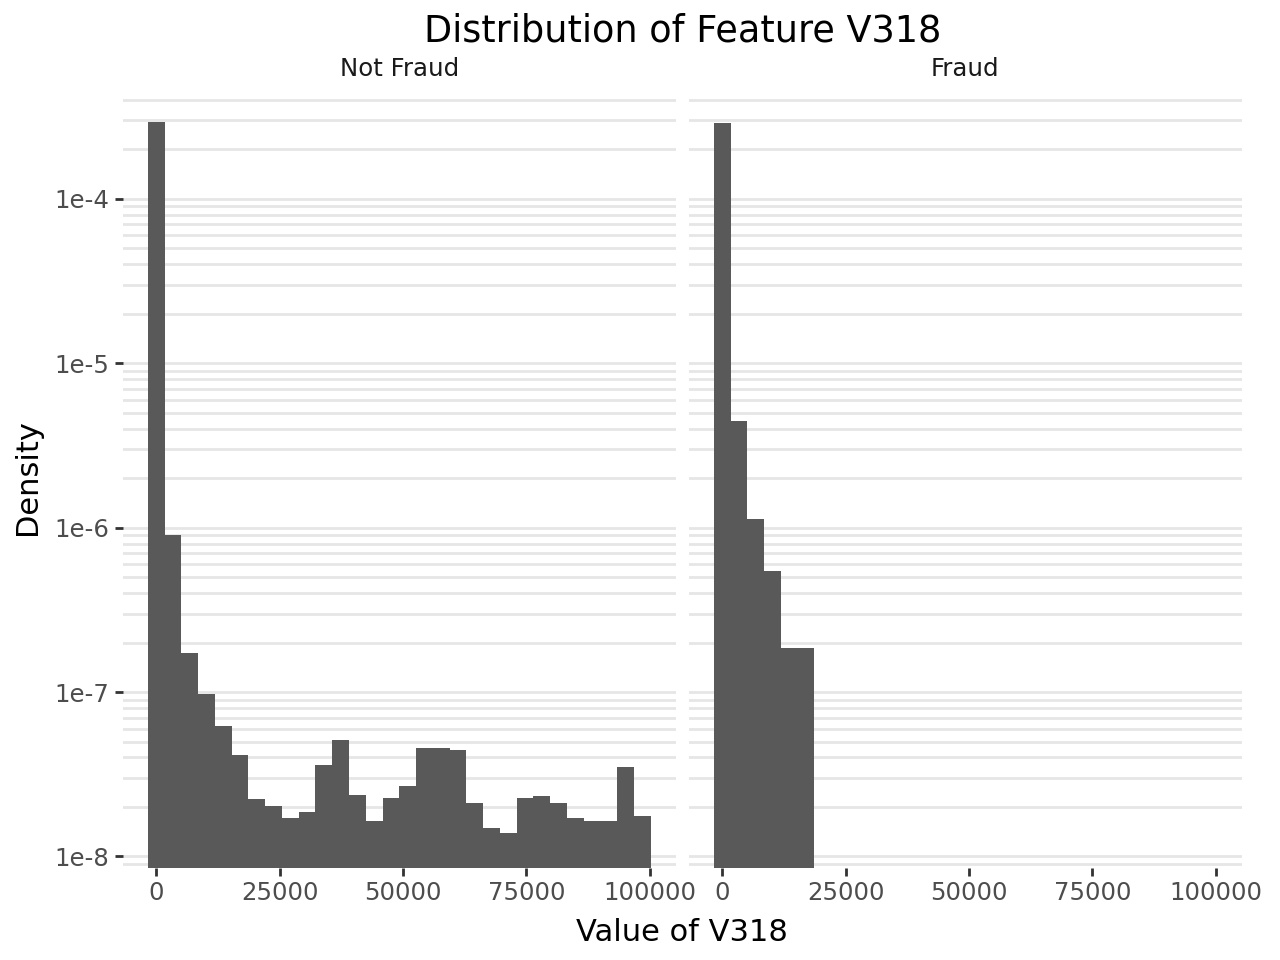

In [ ]:
supervised_hist("V318", bins=30)

### V257

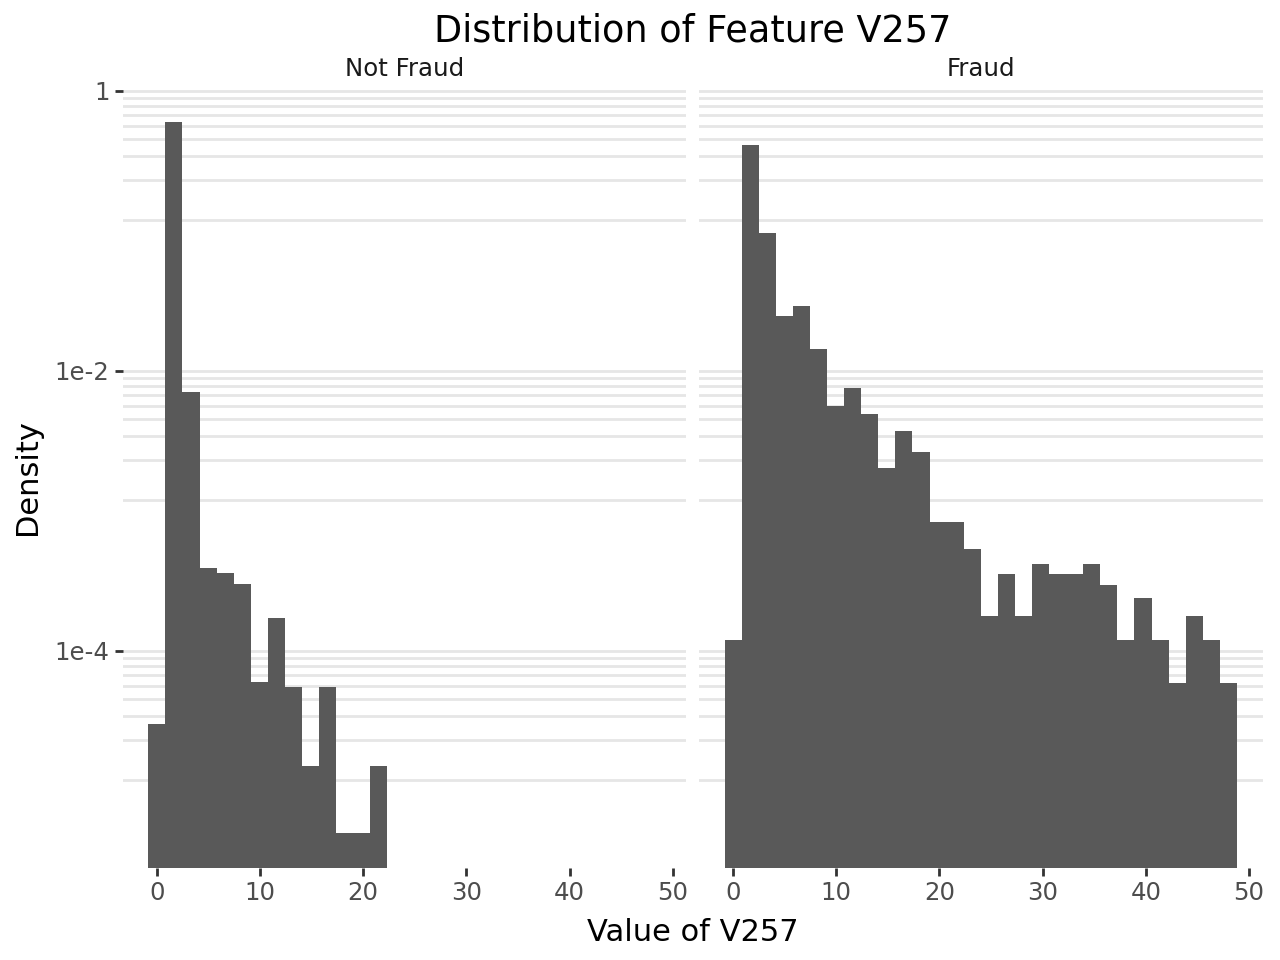

In [ ]:
supervised_hist("V257", bins=30)

### C4

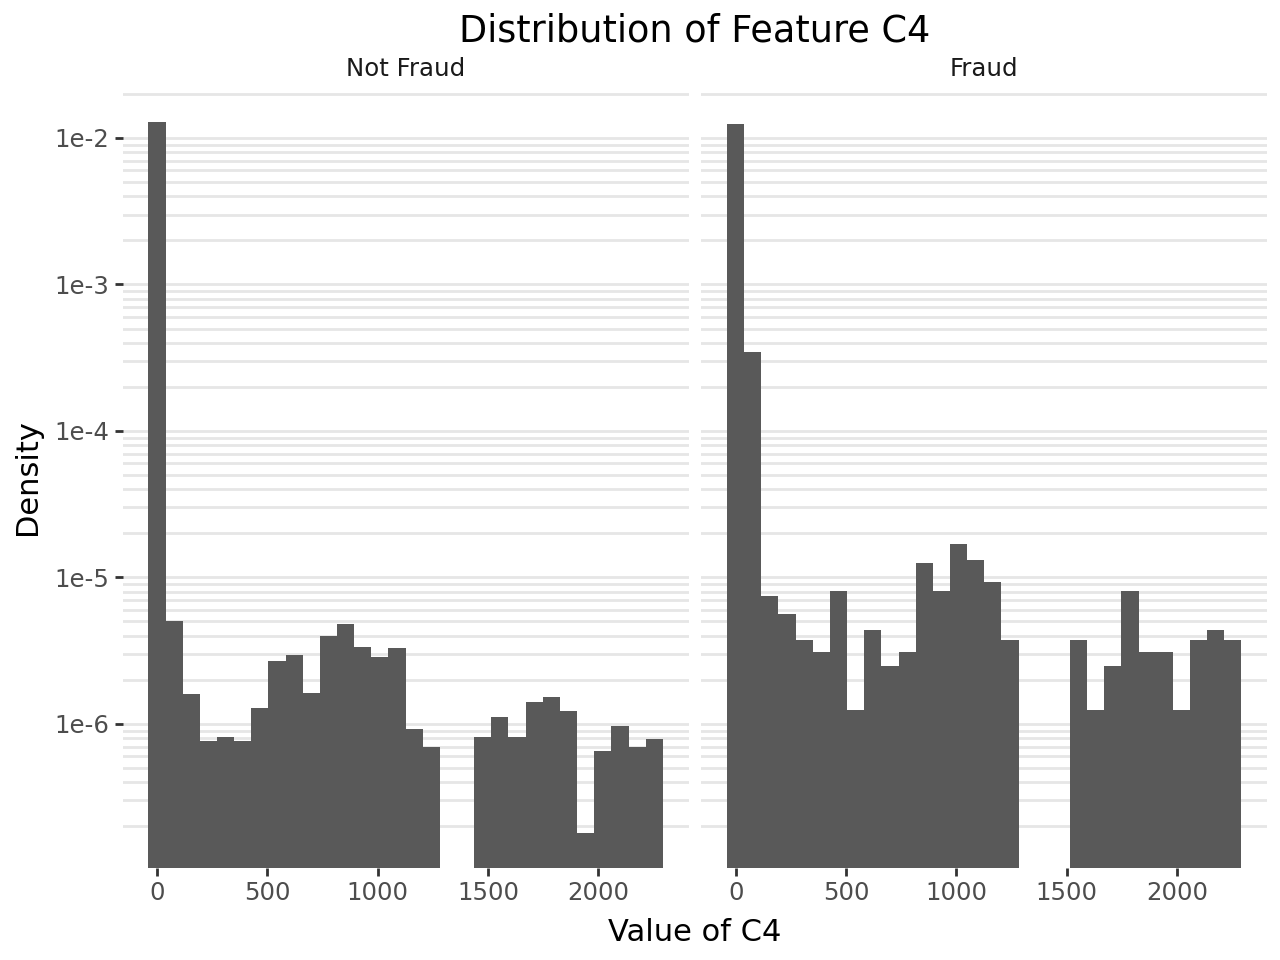

In [ ]:
supervised_hist("C4", bins=30)

# Data Preprocessing

Let's begin by merging together the features the training dataset into a single dataframe and splitting the dataframe into training, test, and validation dataframes.

In [ ]:
whole = train_transaction.merge(train_identity, on='TransactionID', how='left')

# one hot encode the categorical variables

whole = whole.sort_values(by="TransactionDT")

X = whole[whole.columns.difference(['isFraud'])]
X = pd.get_dummies(X, drop_first=True)
y = whole['isFraud']

n = len(whole)

del whole

X_train = X[:-int(n * 0.2)]
X_test = X[-int(n * 0.2):]

y_train = y[:-int(n * 0.2)]
y_test = y[-int(n * 0.2):]

del X
del y

## Data Imputation

We will attempt various imputation strategies to fill missing gaps in the the data

### Mean/Median/Mode

In [ ]:
def basic_impute(X, impute_method = "mean"):
  preprocessor = ColumnTransformer(
      transformers=[
          ("num", SimpleImputer(strategy=impute_method),
           selector(dtype_exclude="object")),
          ("cat", SimpleImputer(strategy="most_frequent"),
           selector(dtype_include="object")),
      ]
  )

  preprocessor.fit(X)

  imputed_values = pd.DataFrame(preprocessor.transform(X),
                                columns=X.columns)

  ind_names = [name + "_ind" for name in X.columns]
  indicators = pd.DataFrame(MissingIndicator(features="all").fit_transform(X),
                            columns=ind_names)

  return pd.concat([imputed_values, indicators], axis = 1)

In [ ]:
whole = train_transaction.merge(train_identity, on='TransactionID', how='left')
whole = whole.sort_values(by="TransactionDT")

X = whole[whole.columns.difference(['isFraud'])]
y = whole['isFraud']

del whole

In [ ]:
save_location = "./drive/My Drive/ieee-fraud-detection/interpolated/mean_interpolated.csv"
if not os.path.isfile(save_location):
  X_mean = basic_impute(X)
  X_mean.to_csv(save_location)
  del X_mean

In [ ]:
save_location = "./drive/My Drive/ieee-fraud-detection/interpolated/median_interpolated.csv"
if not os.path.isfile(save_location):
  X_median = basic_impute(X, impute_method = "median")
  X_median.to_csv(save_location)
  del X_median

### Multivariate Imputation by Chained Equations

In [ ]:
def mice_impute(X, iterations=10):
  preprocessor = ColumnTransformer(
      transformers=[
          ("num",IterativeImputer(max_iter=iterations,
                                  random_state=random_state),
           selector(dtype_exclude="object")),
          ("cat", SimpleImputer(strategy="most_frequent"),
           selector(dtype_include="object")),
      ]
  )

  imputed_values = pd.DataFrame(preprocessor.fit_transform(X),
                                columns=X.columns)

  ind_names = [name + "_ind" for name in X.columns]
  indicators = pd.DataFrame(MissingIndicator(features="all").fit_transform(X),
                            columns=ind_names)

  return pd.concat([imputed_values, indicators], axis = 1)


save_location = "./drive/My Drive/ieee-fraud-detection/interpolated/mice_interpolated.csv"
if not os.path.isfile(save_location):
  X_mice = mice_impute(X)
  X_mice.to_csv(save_location)
  del X_mice

# Model Training

## Helper Functions

In [ ]:
def find_untested_combos(parameters, csv_location = None):
  """find all the untested combos of parameters for a grid search"""
  parameter_combos = [{k:v for k, v in zip(parameters.keys(), row)} for row in product(*parameters.values())]

  if not csv_location or not os.path.isfile(csv_location):
    print(f"Untested combos: No csv found...")
    return parameter_combos

  existing_output = []
  with open(csv_location) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        existing_output.append(row)

  def process(x):
    if x.isnumeric() or "{" in x or "(" in x or \
       (x.count(".") == 1 and x.replace(".", "").isnumeric()):
      return literal_eval(x)
    else:
      return x

  exclude = [{k : process(v) for k, v in row.items() if k in parameters.keys()} for row in existing_output]

  print(exclude)

  untested_combos = []
  for combo in parameter_combos:
    match = False
    for exclusion in exclude:
      for i, parameter in enumerate(parameters.keys()):
        if combo[parameter] != exclusion[parameter]:
          break
        elif i == len(parameters.keys()) - 1:
          match = True
      if match:
        break
    if not match:
      untested_combos.append(combo)

  print(untested_combos)

  return untested_combos

def run_grid_search(classifier, X, y, combos, scoring_metric, csv_location,
                    load_csv_stub, cv = 5):

  X = pd.get_dummies(X, drop_first=True)

  current_impute = None
  for parameter_dict in combos:

    if "impute_strat" in parameter_dict:
      if current_impute != parameter_dict["impute_strat"]:
        csv_file = load_csv_stub + parameter_dict["impute_strat"] + "_interpolated.csv"
        current_impute = parameter_dict["impute_strat"]
        del X
        X = pd.get_dummies(pd.read_csv(csv_file)[:-int(n * 0.2)], drop_first=True)
      del parameter_dict["impute_strat"]

    clf = classifier(**parameter_dict)

    n = len(X)
    unit = int(n / cv)

    scores = {
          "training_score" : [],
          "validation_score" : []
      }

    scorer = get_scorer(scoring_metric)._score_func

    for i in range(cv - 1):
      index = (i + 1) * unit
      X_train = X[index - unit:index]
      y_train = y[index - unit:index]
      X_val = X[index:index + unit]
      y_val = y[index:index + unit]

      if "class_weight" in parameter_dict:
        weights = [parameter_dict["class_weight"][x] for x in y_train]
      else:
          weights = [1] * len(y_train)

      if classifier is XGBClassifier:
        clf.fit(X_train, y_train, sample_weight=weights)
      else:
        clf.fit(X_train, y_train)

      y_pred_train = clf.predict(X_train)
      y_pred_val = clf.predict(X_val)

      training_score = scorer(y_train, y_pred_train)
      scores["training_score"].append(training_score)

      validation_score = scorer(y_val, y_pred_val)
      scores["validation_score"].append(validation_score)

    if current_impute:
      parameter_dict.update({"impute_strat" : current_impute})

    parameter_dict.update({"scoring_metric" : scoring_metric})

    score_means = {key : mean(value) for key, value in scores.items()}
    parameter_dict.update(score_means)

    if not os.path.isfile(csv_location):
        print(f"File {csv_location} does not exist, creating...")
        print(f"results: {parameter_dict}")
        with open(csv_location, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile,
                                    fieldnames=parameter_dict.keys())
            writer.writeheader()
            writer.writerow(parameter_dict)
    else:
        print(f"Appending results to {csv_location}...")
        print(f"results: {parameter_dict}")
        with open(csv_location, 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile,
                                    fieldnames=parameter_dict.keys())
            writer.writerow(parameter_dict)



## Logistic Regression


In [ ]:
parameters = {
    'impute_strat' : ['mean', 'median', 'mice'],
    'C' : [100, 10, 1, 0.1, .01, .001],
    'class_weight' : [{0: 1, 1: 1},  {0: 1, 1: 10}, {0: 1, 1: 20},
                      {0: 1, 1: 30}, {0: 1, 1: 40}, {0: 1, 1: 50},
                      {0: 1, 1: 60}, {0: 1, 1: 70}, {0: 1, 1: 80},
                      {0: 1, 1: 90}]
}
scoring_metric = 'average_precision'

untested_combos = find_untested_combos(parameters, "./drive/My Drive/ieee-fraud-detection/output/lr_results.csv")
run_grid_search(LogisticRegression, X_train, y_train, untested_combos, scoring_metric,
                csv_location="./drive/My Drive/ieee-fraud-detection/output/lr_results.csv",
                load_csv_stub="./drive/My Drive/ieee-fraud-detection/interpolated/")

File ./drive/My Drive/ieee-fraud-detection/output/lr_results.csv does not exist, creating...
results: {'C': 100, 'class_weight': {0: 1, 1: 40}, 'impute_strat': 'mean', 'scoring_metric': 'average_precision', 'training_score': np.float64(0.040425878095003545), 'validation_score': np.float64(0.045235039097917)}
Appending results to ./drive/My Drive/ieee-fraud-detection/output/lr_results.csv...
results: {'C': 100, 'class_weight': {0: 1, 1: 50}, 'impute_strat': 'mean', 'scoring_metric': 'average_precision', 'training_score': np.float64(0.03724384150535452), 'validation_score': np.float64(0.044985860311411524)}
Appending results to ./drive/My Drive/ieee-fraud-detection/output/lr_results.csv...
results: {'C': 100, 'class_weight': {0: 1, 1: 60}, 'impute_strat': 'mean', 'scoring_metric': 'average_precision', 'training_score': np.float64(0.03534925182332933), 'validation_score': np.float64(0.039134093875102895)}
Appending results to ./drive/My Drive/ieee-fraud-detection/output/lr_results.csv...


In [ ]:
pd.read_csv("./drive/My Drive/ieee-fraud-detection/output/lr_results.csv")\
.sort_values(by="validation_score", ascending=False).head()

,C,class_weight,impute_strat,scoring_metric,training_score,validation_score
57,100.00,"{0: 1, 1: 10}",median,average_precision,0.060297,0.059737
58,100.00,"{0: 1, 1: 20}",median,average_precision,0.064400,0.058226
9,10.00,"{0: 1, 1: 30}",mean,average_precision,0.047497,0.053322
38,0.01,"{0: 1, 1: 20}",mean,average_precision,0.053423,0.051997
61,100.00,"{0: 1, 1: 50}",median,average_precision,0.038354,0.051537


In [ ]:
whole = train_transaction.merge(train_identity, on='TransactionID', how='left')
whole = whole.sort_values(by="TransactionDT")

csv_file = "./drive/My Drive/ieee-fraud-detection/interpolated/median_interpolated.csv"
X = pd.read_csv(csv_file).sort_values(by="TransactionDT")
X = pd.get_dummies(X, drop_first=True)
y = whole['isFraud']

n = len(whole)

del whole

X_train = X[:-int(n * 0.2)]
X_test = X[-int(n * 0.2):]

y_train = y[:-int(n * 0.2)]
y_test = y[-int(n * 0.2):]

del X
del y

In [ ]:
clf = LogisticRegression(C = 100, class_weight={0: 1, 1: 10})
clf.fit(X_train, y_train)

LogisticRegression(C=100, class_weight={0: 1, 1: 10})

In [ ]:
y_pred_train = clf.predict(X_train)
y_prob_train = clf.predict_proba(X_train)[:,1]
y_pred_test = clf.predict(X_test)
y_prob_test = clf.predict_proba(X_test)[:,1]

In [ ]:
prob_prediction = pd.DataFrame({
    "actual" : y_test,
    "probability" : y_prob_test
}).sort_values(by="probability", ascending=False)

In [ ]:
metrics_lr = {
    "Model" : "Logistic Regression",
    "Train AUC" : roc_auc_score(y_train, y_prob_train),
    "Test AUC" : roc_auc_score(y_test, y_prob_test),
    "Train PR AUC" : average_precision_score(y_train, y_prob_train),
    "Test PR AUC" : average_precision_score(y_test, y_prob_test),
    "Precision K5": np.mean(prob_prediction.actual[:5]),
    "Precision K10": np.mean(prob_prediction.actual[:10]),
}

metrics_lr

{'Model': 'Logistic Regression',
 'Train AUC': np.float64(0.5438048873285058),
 'Test AUC': np.float64(0.5049847044979462),
 'Train PR AUC': np.float64(0.03987733546954477),
 'Test PR AUC': np.float64(0.03490603188749599),
 'Precision K5': np.float64(0.0),
 'Precision K10': np.float64(0.0)}

## Multi-Layer Perceptron

In [ ]:
options = list(reversed([2 ** i for i in range(4, 10)]))
options = options + [0]

layer_combos = []
for i, layer_1 in enumerate(options[:-1]):
  for j, layer_2 in enumerate(options[i:]):
    if layer_2 == 0:
      layer_combos.append((layer_1,))
      continue
    for layer_3 in options[i+j:]:
      if layer_3 == 0:
        layer_combos.append((layer_1, layer_2))
        continue
      layer_combos.append((layer_1, layer_2, layer_3))

In [ ]:
parameters = {
    'impute_strat' : ['mean', 'median', 'mice'],
    'hidden_layer_sizes' : layer_combos,
    'max_iter' : [50]
}
scoring_metric = 'average_precision'

untested_combos = find_untested_combos(parameters, "./drive/My Drive/ieee-fraud-detection/output/mlp_results.csv")
run_grid_search(MLPClassifier, X_train, y_train, untested_combos, scoring_metric,
                csv_location="./drive/My Drive/ieee-fraud-detection/output/mlp_results.csv",
                load_csv_stub="./drive/My Drive/ieee-fraud-detection/interpolated/")

NameError: name 'find_untested_combos' is not defined

In [ ]:
pd.read_csv("./drive/My Drive/ieee-fraud-detection/output/mlp_results.csv")\
.sort_values(by="validation_score", ascending=False).head()

,hidden_layer_sizes,max_iter,impute_strat,scoring_metric,training_score,validation_score
199,"(256, 256)",50,mice,average_precision,0.054081,0.061084
242,"(32, 32)",50,mice,average_precision,0.055852,0.060474
187,"(512, 64)",50,mice,average_precision,0.056527,0.057995
172,"(512, 512)",50,mice,average_precision,0.052938,0.057124
79,"(32,)",50,mean,average_precision,0.076177,0.056624


In [ ]:
whole = train_transaction.merge(train_identity, on='TransactionID', how='left')
whole = whole.sort_values(by="TransactionDT")

csv_file = "./drive/My Drive/ieee-fraud-detection/interpolated/mice_interpolated.csv"
X = pd.read_csv(csv_file).sort_values(by="TransactionDT")
X = pd.get_dummies(X, drop_first=True)
y = whole['isFraud']

n = len(whole)

del whole

X_train = X[:-int(n * 0.2)]
X_test = X[-int(n * 0.2):]

y_train = y[:-int(n * 0.2)]
y_test = y[-int(n * 0.2):]

del X
del y

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(256, 256), max_iter=200)
clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(256, 256))

In [ ]:
y_pred_train = clf.predict(X_train)
y_prob_train = clf.predict_proba(X_train)[:,1]
y_pred_test = clf.predict(X_test)
y_prob_test = clf.predict_proba(X_test)[:,1]

In [ ]:
prob_prediction = pd.DataFrame({
    "actual" : y_test,
    "probability" : y_prob_test
}).sort_values(by="probability", ascending=False)

In [ ]:
metrics_mlp = {
    "Model" : "Multi-Layer Perceptron",
    "Train AUC" : roc_auc_score(y_train, y_prob_train),
    "Test AUC" : roc_auc_score(y_test, y_prob_test),
    "Train PR AUC" : average_precision_score(y_train, y_prob_train),
    "Test PR AUC" : average_precision_score(y_test, y_prob_test),
    "Precision K5": np.mean(prob_prediction.actual[:5]),
    "Precision K10": np.mean(prob_prediction.actual[:10]),
}

metrics_mlp

{'Model': 'Multi-Layer Perceptron',
 'Train AUC': np.float64(0.5000113060791054),
 'Test AUC': np.float64(0.49992985163621056),
 'Train PR AUC': np.float64(0.035136041653831225),
 'Test PR AUC': np.float64(0.034409184813899145),
 'Precision K5': np.float64(0.0),
 'Precision K10': np.float64(0.0)}

## Random Forest

In [ ]:
parameters = {
    'n_estimators' : [100, 1000],
    'criterion' : ['gini'],
    'max_depth' : [10],
    'class_weight' : [{0: 1, 1: 10}, {0: 1, 1: 20}, {0: 1, 1: 30},
                      {0: 1, 1: 40}, {0: 1, 1: 50}, {0: 1, 1: 60},
                      {0: 1, 1: 70}, {0: 1, 1: 80}, {0: 1, 1: 90}],
    'min_samples_split' : [32],
    'min_samples_leaf' : [32]
}

scoring_metric = 'average_precision'

untested_combos = find_untested_combos(parameters, "./drive/My Drive/ieee-fraud-detection/output/rf_results.csv")
run_grid_search(RandomForestClassifier, X_train, y_train, untested_combos,
                scoring_metric, csv_location="./drive/My Drive/ieee-fraud-detection/output/rf_results.csv",
                load_csv_stub="./drive/My Drive/ieee-fraud-detection/interpolated/")

In [ ]:
pd.read_csv("./drive/My Drive/ieee-fraud-detection/output/rf_results.csv")\
.sort_values(by="validation_score", ascending=False).head()

,n_estimators,criterion,max_depth,class_weight,min_samples_split,min_samples_leaf,scoring_metric,training_score,validation_score
0,100,gini,10,"{0: 1, 1: 10}",32,32,average_precision,0.307064,0.231935
9,1000,gini,10,"{0: 1, 1: 10}",32,32,average_precision,0.305830,0.228504
10,1000,gini,10,"{0: 1, 1: 20}",32,32,average_precision,0.210953,0.173750
1,100,gini,10,"{0: 1, 1: 20}",32,32,average_precision,0.208531,0.172455
11,1000,gini,10,"{0: 1, 1: 30}",32,32,average_precision,0.154174,0.137490


In [ ]:
whole = train_transaction.merge(train_identity, on='TransactionID', how='left')
whole = whole.sort_values(by="TransactionDT")

X = whole[whole.columns.difference(['isFraud'])]
X = pd.get_dummies(X, drop_first=True)
y = whole['isFraud']

n = len(whole)

del whole

X_train = X[:-int(n * 0.2)]
X_test = X[-int(n * 0.2):]

y_train = y[:-int(n * 0.2)]
y_test = y[-int(n * 0.2):]

del X
del y

In [ ]:
clf = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=10,
                             class_weight={0: 1, 1: 10}, min_samples_split=32,
                             min_samples_leaf=32)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=10,
                       min_samples_leaf=32, min_samples_split=32)

In [ ]:
y_pred_train = clf.predict(X_train)
y_prob_train = clf.predict_proba(X_train)[:,1]
y_pred_test = clf.predict(X_test)
y_prob_test = clf.predict_proba(X_test)[:,1]

In [ ]:
prob_prediction = pd.DataFrame({
    "actual" : y_test,
    "probability" : y_prob_test
}).sort_values(by="probability", ascending=False)

In [ ]:
metrics_rf = {
    "Model" : "Random Forest",
    "Train AUC" : roc_auc_score(y_train, y_prob_train),
    "Test AUC" : roc_auc_score(y_test, y_prob_test),
    "Train PR AUC" : average_precision_score(y_train, y_prob_train),
    "Test PR AUC" : average_precision_score(y_test, y_prob_test),
    "Precision K5": np.mean(prob_prediction.actual[:5]),
    "Precision K10": np.mean(prob_prediction.actual[:10]),
}

metrics_rf

{'Model': 'Random Forest',
 'Train AUC': np.float64(0.8792513020791594),
 'Test AUC': np.float64(0.8572018732944489),
 'Train PR AUC': np.float64(0.5167209967867394),
 'Test PR AUC': np.float64(0.4268017045567174),
 'Precision K5': np.float64(1.0),
 'Precision K10': np.float64(1.0)}

## Extreme Gradient Boosting

In [ ]:
parameters = {
    'learning_rate' : [0.1, 1],
    'max_iter' : [50, 100, 200],
    'max_depth' : [1, 2, 4, 6, 8, 10],
    'class_weight' : [{0: 1, 1: 1},  {0: 1, 1: 10}, {0: 1, 1: 20},
                      {0: 1, 1: 30}, {0: 1, 1: 40}, {0: 1, 1: 50},
                      {0: 1, 1: 60}, {0: 1, 1: 70}, {0: 1, 1: 80},
                      {0: 1, 1: 90}]
}

untested_combos = find_untested_combos(parameters, "./drive/My Drive/ieee-fraud-detection/output/xgb_results.csv")
run_grid_search(XGBClassifier, X_train, y_train, untested_combos,
                scoring_metric="average_precision",
                csv_location="./drive/My Drive/ieee-fraud-detection/output/xgb_results.csv",
                load_csv_stub="./drive/My Drive/ieee-fraud-detection/interpolated/")

In [ ]:
pd.read_csv("./drive/My Drive/ieee-fraud-detection/output/xgb_results.csv")\
.sort_values(by="validation_score", ascending=False).head()

,learning_rate,max_iter,max_depth,class_weight,scoring_metric,training_score,validation_score
55,0.1,50,10,"{0: 1, 1: 1}",average_precision,0.727967,0.325645
115,0.1,100,10,"{0: 1, 1: 1}",average_precision,0.727967,0.325645
175,0.1,200,10,"{0: 1, 1: 1}",average_precision,0.727967,0.325645
165,0.1,200,8,"{0: 1, 1: 1}",average_precision,0.615645,0.321619
45,0.1,50,8,"{0: 1, 1: 1}",average_precision,0.615645,0.321619


In [ ]:
whole = train_transaction.merge(train_identity, on='TransactionID', how='left')
whole = whole.sort_values(by="TransactionDT")

X = whole[whole.columns.difference(['isFraud'])]
X = pd.get_dummies(X, drop_first=True)
y = whole['isFraud']

n = len(whole)

del whole

X_train = X[:-int(n * 0.2)]
X_test = X[-int(n * 0.2):]

y_train = y[:-int(n * 0.2)]
y_test = y[-int(n * 0.2):]

del X
del y

In [ ]:
clf = XGBClassifier(learning_rate=0.1, max_iter=200, max_depth=10)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_iter=200, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred_train = clf.predict(X_train)
y_prob_train = clf.predict_proba(X_train)[:,1]
y_pred_test = clf.predict(X_test)
y_prob_test = clf.predict_proba(X_test)[:,1]

In [ ]:
prob_prediction = pd.DataFrame({
    "actual" : y_test,
    "probability" : y_prob_test
}).sort_values(by="probability", ascending=False)

In [ ]:
metrics_xgb = {
    "Model" : "XGBoost",
    "Train AUC" : roc_auc_score(y_train, y_prob_train),
    "Test AUC" : roc_auc_score(y_test, y_prob_test),
    "Train PR AUC" : average_precision_score(y_train, y_prob_train),
    "Test PR AUC" : average_precision_score(y_test, y_prob_test),
    "Precision K5": np.mean(prob_prediction.actual[:5]),
    "Precision K10": np.mean(prob_prediction.actual[:10]),
}

metrics_xgb

{'Model': 'XGBoost',
 'Train AUC': np.float64(0.980381428490773),
 'Test AUC': np.float64(0.917416700587244),
 'Train PR AUC': np.float64(0.8782278326592479),
 'Test PR AUC': np.float64(0.5587757014199076),
 'Precision K5': np.float64(1.0),
 'Precision K10': np.float64(1.0)}

# Results

In [ ]:
pd.DataFrame([metrics_lr, metrics_mlp, metrics_rf, metrics_xgb])

,Model,Train AUC,Test AUC,Train PR AUC,Test PR AUC,Precision K5,Precision K10
0,Logistic Regression,0.543805,0.504985,0.039877,0.034906,0.0,0.0
1,Multi-Layer Perceptron,0.500011,0.499930,0.035136,0.034409,0.0,0.0
2,Random Forest,0.879251,0.857202,0.516721,0.426802,1.0,1.0
3,XGBoost,0.980381,0.917417,0.878228,0.558776,1.0,1.0
